# Introdução

**Autor: Jackson Souza Corrêa**

LikedIn: https://www.linkedin.com/in/jackson-corr%C3%AAa/

GitHub: https://github.com/JacksonSCorrea

##Importação de bibliotecas

In [ ]:
# Instalação de bibliotecas
!pip install category_encoders

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from category_encoders import CatBoostEncoder

import warnings
warnings.filterwarnings("ignore")

##Definição de funções

###Metadados

In [82]:
# Função de Metadados
def report_data(df, **kwargs):

  '''
  Função que cria um dataframe resumo de valores missing e outliers no dataframe original
  Argumento obrigatório: dataframe
  Argumento opcional: k (valor do fator de multiplicação para o cálculo do limite de outliers)
  '''

  df2 = pd.DataFrame()
  df2['Feature'] = list(df.columns)
  df2['Tipo'] = df.dtypes.values
  df2['Card'] = df.nunique().values
  df2['qtd miss'] = df.isnull().sum().values
  df2['%Miss'] = round(100 * df2['qtd miss'] / df.shape[0] , 1)


  Q1 = df.quantile(0.25)    #primeiro quartil (percentil 25)
  Q3 = df.quantile(0.75)    #terceiro quartil (percentil 75)
  IIQ = Q3 - Q1             #intervalo interquartil
  k = kwargs.get('k', 1.5)  #Fator multiplicador
  LS = Q3 + k*IIQ           #Limite superior
  LI = Q1 - k*IIQ           #Limite inferior

  df2['qtd out sup'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])>LS].count().values
  df2['%Out_sup'] = round(100 * df2['qtd out sup'] / df.shape[0] , 1)


  df2['qtd out inf'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])<LI].count().values
  df2['%Out_inf'] = round(100 * df2['qtd out inf'] / df.count().values , 1)

  df2['qtd outliers'] = df2['qtd out sup'] + df2['qtd out inf']
  df2['%Outliers'] = round(100 * df2['qtd outliers'] / df.count().values , 1)


  # Inicialize um DataFrame vazio para armazenar as modas e suas frequências percentuais
  moda_e_frequencia = pd.DataFrame(columns=['Moda', 'Frequência Percentual'])

  # Itere sobre as colunas do DataFrame
  for coluna in df.columns:
      moda = df[coluna].mode().values[0]  # Encontre a moda da coluna
      frequencia = (df[coluna] == moda).mean() * 100  # Calcule a frequência percentual
      moda_e_frequencia = moda_e_frequencia.append({'Moda': moda, '%Freq': round(frequencia,1)}, ignore_index=True)

  df2['Moda'] = moda_e_frequencia['Moda']
  df2['%Freq'] = moda_e_frequencia['%Freq']


  # Quantidade de variáveis com valores faltantes:
  qtd_miss = sum(list(df2.isna().sum()))

  # Quantidade de features numéricas e categóricas
  qtd_numerica = sum(list(df2.loc[(df2['Tipo']=='float') | (df2['Tipo']=='int32')|(df2['Tipo']=='int64'),['Feature']].count()))
  qtd_categorica = sum(list(df2.loc[df2['Tipo']=='object' , ['Feature']].count()))

  # Cálculo da cardinalidade total das variáveis categóricas
  qtd_card_tot = sum(list(df2.loc[(df2['Tipo']=='object') , ['Card']].sum()))

  # Cálculo da quantidade de linhas duplicadas
  dup = df.duplicated().sum()

  # Estilo ANSI para negrito e amarelo
  amarelo = "\033[1;33m"

  # Resetar estilo ANSI (para evitar que o texto seguinte também seja vermelho)
  resetar_estilo = "\033[0m"

  print(f'''{amarelo}
  Quantidade de linhas duplicadas: {dup}  |  Quantidade de features com valores faltantes: {qtd_miss}
  Quantidade de features numéricas: {qtd_numerica}  |  Quantidade de features categóricas {qtd_categorica}
  Cardinalidade total das categóricas: {qtd_card_tot}  |  Dataframe: {df.shape[0]} linhas, {df.shape[1]} colunas
        {resetar_estilo}''')

  # Dropa colunas desnecessárias
  df2.drop(['qtd miss','qtd out sup' , 'qtd out inf', 'qtd outliers'], axis=1 , inplace=True)


  return df2

###Dataprep

In [83]:
def dataprep(df, target, metadados, lim_miss, lim_card, scaled, encoder_method, convert_target, stratify):

  # df = df
  # metadados = df_report
  # lim_miss = 800
  # lim_card = 20
  # scaled = 'all'
  # encoder_method = 'onehot+label'
  # convert_target = 'yes'
  # stratify = 'yes'

  # Função para automação da etapa de preparação dos dados
  # Esta função salva as diversas etapas de transformação dos
  # dados de treino (X_train) e de teste (X_test).
  # A função também retorna todos os conjuntos de dados e os artefatos
  # utilizados na transformação, como os encoders, o scaler, as modas imputadas, etc

  #----------------------------------------------------------------------------------------------
  # Dropando linhas duplicadas
  #----------------------------------------------------------------------------------------------

  # df.drop_duplicates(inplace=True, keep='first')


  #----------------------------------------------------------------------------------------------
  # Separando dados de treino e teste antes de qualquer manipulação - evitar DataLeakage
  #----------------------------------------------------------------------------------------------

  # Divisão X e Y
  X = df.drop(target, axis=1)
  y = df[target]

  # Divisão treino e teste
  if stratify=='no':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)                  #sem estratificação
  elif stratify == 'yes':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y) # estratifica pela target

  #----------------------------------------------------------------------------------------------
  # Dropando colunas com alto percentual de missing
  #----------------------------------------------------------------------------------------------

  # Limites
  lim_miss = lim_miss

  # Lista de variáveis com miss acima do limiar
  lista_var = list(metadados.loc[metadados['%Miss'] > lim_miss, 'Feature'])

  # Dropando em X_train
  X_train.drop(lista_var, axis=1, inplace=True)

  # Dropando em X_test
  X_test.drop(lista_var, axis=1, inplace=True)


  #----------------------------------------------------------------------------------------------
  # Definindo colunas numéricas e categóricas
  #----------------------------------------------------------------------------------------------

  num_var = list(X_train.select_dtypes(include=('int32','int64','float')).columns)
  cat_var = list(X_train.select_dtypes(include='object').columns)


  #----------------------------------------------------------------------------------------------
  # Imputando valores
  #----------------------------------------------------------------------------------------------

  # Imputando valores das numéricas - 'mediana' de cada cariável
  mediana = X_train[num_var].median()                 #mediana calculada nos dados de treino
  X_train[num_var] = X_train[num_var].fillna(mediana) #imputando nos dados de treino
  X_test[num_var] = X_test[num_var].fillna(mediana)   #imputando nos dados de teste

  # Imputando valores das categóricas - 'sem_info'
  cat_input = 'sem_info'
  X_train[cat_var] = X_train[cat_var].fillna(cat_input) #imputando nos dados de treino
  X_test[cat_var] = X_test[cat_var].fillna(cat_input)   #imputando nos dados de teste

  # Dicionário de valores usados para imputação
  list_modes_imput = X_train.mode().iloc[0].to_dict()


  #----------------------------------------------------------------------------------------------
  # Codificação da target
  #----------------------------------------------------------------------------------------------

  if convert_target == 'yes':
    # Instanciando
    encoder_target = LabelEncoder()

    # Aplicando treino e teste
    y_train = encoder_target.fit_transform(y_train)   #Fit e transform
    y_test = encoder_target.transform(y_test)          #Apenas transform
  else:
    encoder_target = None


  #----------------------------------------------------------------------------------------------
  # Codificação de variáveis categóricas
  #----------------------------------------------------------------------------------------------

  # Copiando
  X_train_enc = X_train.copy()
  X_test_enc = X_test.copy()

  # Limite de cardinalidade para aplicar um ou outro encoder
  lim_card = lim_card

  # Separando variáveis de alta e baixa cardinalidade
  alta_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() > lim_card])
  baixa_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() <= lim_card])

  # Se foi definido OneHotEncoder + LabelEncoder
  # Ideal para feature selection
  if encoder_method == 'onehot+label':

    # Instanciando - Label Encoder nas de alta cardinalidade
    label_encoder = LabelEncoder()

    # Label encoder - alta cardinalidade
    for i in alta_card:
      X_train_enc[i] = label_encoder.fit_transform(X_train_enc[i]) #Fit_transform nos dados de treino
      X_test_enc[i] = label_encoder.transform(X_test_enc[i])       #Somente transform nos dados de teste

    # Crie e aplique o OneHotEncoder
    OneHot_encoder = OneHotEncoder(sparse=False, drop='first')

    # Aplicando OneHotEncoding nos conjuntos de treino e teste
    encoded_data = OneHot_encoder.fit_transform(X_train_enc[baixa_card]) #Fit_transform nos dados de treino

    # Criando dataframe com as colunas codificadas, mantendo o índice original
    encoded_cols = OneHot_encoder.get_feature_names_out(baixa_card)
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=X_train_enc.index)

    # Concatenando o dataframe codificado com o dataframe original em X_train
    X_train_enc = pd.concat([X_train_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

    # Aplicando OneHotEncoding em X_test
    encoded_data = OneHot_encoder.transform(X_test_enc[baixa_card]) #Somente transform nos dados de teste

    # Criando dataframe com as colunas codificadas, mantendo o índice original
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=X_test_enc.index)

    # Concatenando o dataframe codificado com o dataframe original em X_test
    X_test_enc = pd.concat([X_test_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

  # Se foi definido Catboost
  # Ideal para o modelo em si
  elif encoder_method == 'catboost':

    # Instanciando
    cat_encoder = CatBoostEncoder(cols=cat_var)

    # Aplicando as transformações
    X_train_enc = cat_encoder.fit_transform(X_train_enc, y_train)  #fit.transform
    X_test_enc = cat_encoder.transform(X_test_enc)                 #somente "transform"


  #----------------------------------------------------------------------------------------------
  # Padronização dos dados (não precisa para árvores)
  #----------------------------------------------------------------------------------------------

  # Futuramente pode-se criar um parâmetro informando se esta etapa será executada ou não (ganho computacional)

  # Criando cópia
  X_train_enc_std = X_train_enc.copy()
  X_test_enc_std = X_test_enc.copy()

  # Instanciando
  scaler = StandardScaler()

  # Aplicando o scaler somente nas colunas originalmente numéricas
  if scaled == 'num':
      qtd_scaler = len(num_var)  # Quantidade de variáveis ao qual foi aplicado o scaler
      list_var_scaled = num_var  # Lista de variáveis que passarão pelo scaler
      X_train_enc_std[num_var] = scaler.fit_transform(X_train_enc_std[num_var])  # Aplica fit_transform nos dados de treino
      X_test_enc_std[num_var] = scaler.transform(X_test_enc_std[num_var])        # Somente transform nos dados de teste

  # Aplicando o scaler em todas as colunas (após o encoder das categóricas)
  elif scaled == 'all':
      qtd_scaler = len(list(X_train.columns))  # Quantidade de variáveis ao qual foi aplicado o scaler
      list_var_scaled = list(X_train.columns)  # Lista de variáveis que passarão pelo scaler
      X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica fit_transform nos dados de treino
      X_test_enc_std = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)         # ASomente transform nos dados de teste


  #----------------------------------------------------------------------------------------------
  # Objetos finais
  #----------------------------------------------------------------------------------------------

  if encoder_method == 'onehot+label':
    list_var_OneHotEncoder = baixa_card
    list_var_LabelEncoder = alta_card
    list_var_encoder = (list_var_OneHotEncoder , list_var_LabelEncoder)
    # Resumo
    resume = f'''Resumo dataprep:
    Limite de cardinalidade adotado: {lim_card}
    Limite de percentual de nulos adotado: {lim_miss}%
    Quantidade de variáveis dropadas por nulos: {len(lista_var)}
    Quantidade de variáveis ao qual foi aplicado OneHotEncoder: {len(baixa_card)}
    Quantidade de variáveis ao qual foi aplicado LabelEncoder: {len(alta_card)}
    Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''
    encoder = (OneHot_encoder , label_encoder)

  elif encoder_method == 'catboost':
    list_var_CatBoostEncoder = cat_var
    list_var_encoder = list_var_CatBoostEncoder
    # Resumo
    resume = f'''Resumo dataprep:
    Limite de cardinalidade adotado: {lim_card}
    Limite de percentual de nulos adotado: {lim_miss}%
    Quantidade de variáveis dropadas por nulos: {len(lista_var)}
    Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: {len(cat_var)}
    Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''
    encoder = cat_encoder


  class DataPrepResult:
      def __init__(self, X_train, X_train_enc, X_train_enc_std, X_test,
                    X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                    list_var_encoder, list_var_scaled,
                    lista_var, list_modes_imput, resume, encoder, encoder_target):

          self.X_train = X_train
          self.X_train_enc = X_train_enc
          self.X_train_enc_std = X_train_enc_std
          self.X_test = X_test
          self.X_test_enc = X_test_enc
          self.X_test_enc_std = X_test_enc_std
          self.y_train = y_train
          self.y_test = y_test
          self.scaler = scaler
          self.list_var_encoder = list_var_encoder
          self.list_var_scaled = list_var_scaled
          self.list_var_drop = lista_var
          self.list_modes_imput = list_modes_imput
          self.resume = resume
          self.encoder = encoder
          self.encoder_target = encoder_target

  return DataPrepResult(X_train, X_train_enc, X_train_enc_std, X_test,
                        X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                        list_var_encoder, list_var_scaled,
                        lista_var, list_modes_imput, resume,
                        encoder, encoder_target)

###Feature Importance

In [84]:
def fs_importance(X, y, cutoff_importance, plot):
  # Feature importance com RandomForest

  # Importando Random Forest
  from sklearn.ensemble import RandomForestClassifier

  # Instanciando
  rf = RandomForestClassifier(random_state=42 , class_weight='balanced')

  # Treinamento
  rf.fit(X, y)

  # Extraindo a importância das variáveis
  feature_importances = rf.feature_importances_
  features = pd.DataFrame({ 'Feature': X.columns, 'Importance': feature_importances })

  # Ordenar variáveis por importância
  features = features.sort_values(by='Importance', ascending=False)

  # Estabelecer um limite de corte, por exemplo, x% da importância máxima
  cutoff_maximp = cutoff_importance

  cutoff = cutoff_maximp * feature_importances.max()

  # Selecionar variáveis acima do corte
  selected_features = X.columns[feature_importances >= cutoff].tolist()

  # Selecionar variáveis abaixo do corte
  not_selected_features = X.columns[feature_importances < cutoff].tolist()

  # Visualizando a importância das variáveis em barras horizontais
  plt.figure(figsize=(10, 6))
  sorted_idx = feature_importances.argsort()

  print(f'\nFeatures removidas: {len(not_selected_features)}')

  print(f'Features remanescentes: {len(selected_features)}\n')

  lim_plot = 60 #Limite de variáveis para plotar o gráfico

  if plot==True and len(features) <= lim_plot:
    plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color='dodgerblue')  # tom de azul claro
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance com Random Forest")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.axvline(x=cutoff, color='r', linestyle='--', label=f'Ponto de corte = {100*cutoff_maximp:.1f} %\nda importância máxima')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
  else:
    print(f'\033[1;33mO gráfico não será exibido pois a quantidade total de features é maior que {lim_plot}.\033[0m\n')

  return selected_features

###Cálculo de métricas

In [85]:
def calculate_metrics(model_name, model, X_train, y_train, X_test, y_test):

    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])  #Na coluna de indice 1 está a probabilidade de o evento ser 1

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1    #Cálculo do Gini

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) #Na coluna de indice 1 está a probabilidade de o evento ser 1

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1    #Cálculo do Gini

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [model_name, model_name],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df

###Plotagem de métricas

In [86]:
def plot_metrics(model, X_train, y_train, X_test, y_test):

    features = np.array(X_train.columns)

    plt.figure(figsize=(15, 18))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

###Ordena Scores

In [202]:
def ordena_score(model, name_model, X_train, X_test, y_train, y_test):

  # model = rf_opt
  # name_model = 'Decision Tree'

  fix, ax = plt.subplots(1,2,figsize=(14, 6))

  # Previsão das probabilidades no conjunto de treino
  probabilidades = model.predict_proba(X_train)[:, 1]

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_train})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento
  ax[0].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='steelblue')
  ax[0].set_title('Ordenação do Score - Treino - ' + name_model)
  ax[0].set_xlabel('Faixas de Score')
  ax[0].set_ylabel('Taxa de Evento')



  # Previsão das probabilidades no conjunto de teste
  probabilidades = model.predict_proba(X_test)[:, 1]

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_test})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento

  ax[1].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='darkorange')
  ax[1].set_title('Ordenação do Score - Teste - ' + name_model)
  ax[1].set_xlabel('Faixas de Score')
  ax[1].set_ylabel('Taxa de Evento')


  plt.show()

###Plotagens de gráficos

In [88]:
def plot_scatter(df, x_var, y_var, figsize, **kwargs):

    '''Função para plotar o gráfico de dispersão entre variáveis'''

    # Extraindo os argumentos opcionais e atribuindo os valores default
    color = kwargs.get('color', 'deepskyblue')
    marker = kwargs.get('marker', 'o')
    label_size = kwargs.get('label_size', 11)
    grid = kwargs.get('grid', False)

    # Gráfico
    fig, ax = plt.subplots(figsize=figsize)

    sns.scatterplot(data=df, x=x_var, y=y_var, color=color, marker=marker, ax=ax)

    ax.set_title(f'Scatter Plot entre "{x_var}" e "{y_var}"', pad=30, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel(x_var, fontsize=9)
    ax.set_ylabel(y_var, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=label_size)
    ax.grid(grid)

    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.show()

# =======================================================================================================================

def plot_hist(df, var, figsize, **kwargs):

    '''Função para plotar o histgrama de uma variável'''

    # Extraindo os argumentos opcionais e atribuindo os valores default
    color = kwargs.get('color', 'deepskyblue')

    bins = kwargs.get('bins', 30)  # Número de bins no histograma

    pad = kwargs.get('pad', 30)

    label_size = kwargs.get('label_size', 9)

    txt_rot = kwargs.get('txt_rot', 'v')

    stat = kwargs.get('stat', 'frequency')

    grid = kwargs.get('grid', False)


    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    # Gráfico
    fig, ax = plt.subplots(figsize=figsize)

    sns.histplot(data=df, x=var, bins=bins, color=color, ax=ax)

    ax.set_title(f'Histograma da variável "{var}"', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel(var,  fontsize=9)
    ax.set_ylabel(stat, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelsize=label_size)
    ax.tick_params(axis='y', labelsize=label_size)
    ax.grid(grid)

    plt.xticks(rotation=rotation)

    plt.show()

# =======================================================================================================================

def plot_bar(df, var, figsize, **kwargs):
    '''
    Função para plotar o gráfico de barras de uma única variável
    Pode ser entendido como o gráfico de distribuição das categorias de uma variável
    '''

    import textwrap  # Importe a função textwrap

    df_aux = df.copy()
    df_aux[var] = df_aux[var].astype(str)

    # Adicione os argumentos opcionais "top" e "ascending"
    ascending = kwargs.get('ascending', False)
    top = kwargs.get('top', None)

    df_grouped = df_aux.groupby(var).size().sort_values(ascending=ascending)

    tot = df_grouped.sum()
    x = df_grouped.index

    mode = kwargs.get('mode', 'percent')
    cutoff = kwargs.get('corte', None)  # Novo argumento para o ponto de corte
    unity = kwargs.get('unity', '')

    if cutoff is not None:
        if mode == 'percent':
            cutoff_value = tot * (cutoff / 100)
            small_categories = df_grouped[df_grouped < cutoff_value].index
            df_grouped[f'Outros\n(<{cutoff}%)'] = df_grouped[small_categories].sum()
            df_grouped.drop(small_categories, inplace=True)
            x = df_grouped.index
        elif mode == 'absolute':  # Handle cutoff for 'absolute' mode
            small_categories = df_grouped[df_grouped < cutoff].index
            df_grouped[f'Outros\n(<{cutoff}{unity})'] = df_grouped[small_categories].sum()
            df_grouped.drop(small_categories, inplace=True)
            x = df_grouped.index

    color = kwargs.get('color', 'deepskyblue')
    decimals = kwargs.get('decimals', 1)
    pad = kwargs.get('pad', 30)
    dist = kwargs.get('dist', 1)
    label_font = kwargs.get('label_height', 9)
    txt_rot = kwargs.get('txt_rot', 'h')
    title = kwargs.get('title', f'Variável "{var}"')


    if mode == 'percent':
        # Ajuste das proporções de acordo com o corte
        y = 100 * (df_grouped.values / df_grouped.values.sum())
        ylabel = 'Percentual (%)'
    elif mode == 'absolute':
        y = df_grouped.values
        ylabel = 'Número Absoluto'
    else:
        raise ValueError("O modo de exibição deve ser 'percent' ou 'absolute'.")

    if top is not None:
        # Exibir apenas as 10 primeiras barras, mas ajustar as proporções
        x = x[:top]
        y = y[:top]

    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=figsize)

    # Use a função textwrap.fill para formatar os rótulos do eixo X
    x = [textwrap.fill(label, 15) for label in x]

    sns.barplot(x=x, y=y, color=color, alpha=1)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), visible=False)
    ax.set_title(f'{title}', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    plt.gca().set_yticks([])
    plt.gca().set_ylabel('')
    ax.tick_params(axis='x', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for i, v in enumerate(y):
        if mode == 'percent':
            display_value = str(round(v, decimals)) + " %"
        elif mode == 'absolute':
            display_value = str(int(v))
        ax.text(i, v + dist, display_value + ' ' + unity, ha='center', va='bottom', fontsize=label_font, rotation=rotation)

    plt.show()


# =======================================================================================================================

def plot_bar_2var(df, var_x, var_y, figsize, **kwargs):
    '''
    Função para plotar o gráfico de barras entre duas variáveis
    Recebe como entrada as variáveis dos eixos X e Y
    '''

    df_aux = df.copy()

    df_aux[var_x] = df_aux[var_x].astype(str)
    df_aux[var_y] = df_aux[var_y].astype(float)

    # Adicione os argumentos opcionais "top" e "ascending"
    ascending = kwargs.get('ascending', False)
    top = kwargs.get('top', None)

    # Ordene o DataFrame com base no parâmetro "ascending"
    df_aux = df_aux.sort_values(by=var_y, ascending=ascending)

    # Aplicar o argumento "top" se especificado
    if top is not None:
        df_aux = df_aux.head(top)

    x = df_aux[var_x].tolist()
    y = df_aux[var_y].tolist()

    color = kwargs.get('color', 'deepskyblue')
    decimals = kwargs.get('decimals', 1)
    pad = kwargs.get('pad', 30)
    dist = kwargs.get('dist', 1)
    label_font = kwargs.get('label_height', 9)
    txt_rot = kwargs.get('txt_rot', 'h')
    title = kwargs.get('title', f'Gráfico de Barras de "{var_x}" por "{var_y}"')
    unity = kwargs.get('unity', '')

    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(x=x, y=y, color=color, alpha=1)

    ax.set_title(f'{title}', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})

    ax.set_xlabel(var_x)
    plt.gca().set_yticks([])
    plt.gca().set_ylabel('')
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for i, v in enumerate(y):
        display_value = str(round(v, decimals))
        ax.text(i, v + dist, display_value + unity, ha='center', va='bottom', fontsize=label_font, rotation=rotation)

    plt.xticks(rotation=90)

    plt.show()


# =======================================================================================================================

def plot_batch_boxplot(dataframe, **kwargs):
    """
    Plota boxplots estilizados com título simplificado para todas as
    variáveis numéricas do dataframe fornecido em um painel com gráficos
    configurados por linhas e colunas.

    :param dataframe: DataFrame para o qual os boxplots serão gerados.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'skyblue').
    :param b: largura do subplot (opcional, padrão é 15).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    b = kwargs.get('b', 15)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota boxplots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]
        sns.boxplot(data=dataframe[column], ax=ax, color=color)
        ax.set_title(f'{column}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - BoxPlot", fontsize=16, fontweight='bold', y=1.005)

# =======================================================================================================================

def plot_batch_histogram(dataframe, **kwargs):
    """
    Plota histogramas estilizados com título simplificado para todas as
    variáveis numéricas do dataframe fornecido em um painel com gráficos
    configurados por linhas e colunas.

    :param dataframe: DataFrame para o qual os histogramas serão gerados.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param label_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 9).
    :param color: Cor dos subplots (opcional, padrão é 'deepskyblue').
    :param kde: Se True, ativa KDE nos histogramas; se False, desativa (opcional, padrão é False).
    :param bins: Número de bins nos histogramas (opcional, padrão é 30).
    :param stat: Se 'percent', mostra o percentual de cada categoria; se 'frequency', mostra a frequência absoluta (opcional, padrão é 'frequency').
    :param grid: Se True, exibe o grid nos gráficos; se False, não exibe (opcional, padrão é False).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    kde = kwargs.get('kde', False)
    bins = kwargs.get('bins', 30)
    stat = kwargs.get('stat', 'frequency')
    grid = kwargs.get('grid', False)
    b = kwargs.get('b', 15)
    hue = kwargs.get('hue', None)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota histogramas para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]

        # Verificando se foi definida a variável semântica (hue)
        if hue == None:
          sns.histplot(data=dataframe[column], ax=ax, color=color, kde=kde, bins=bins, stat=stat)
        else:
          # sns.histplot(data=dataframe , x=column, ax=ax, color=color, kde=True, element='step', bins=bins, stat=stat, hue=hue)
          sns.kdeplot(data=dataframe, x=column,  ax=ax , fill=True , hue=hue)

        ax.set_title(f'{column}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_ylabel(stat)
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)
            ax.tick_params(axis='x', labelrotation=90)
            ax.get_yaxis().get_major_formatter().set_scientific(False)  # Formatação para números não em notação científica
        ax.grid(grid)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Histograma", fontsize=16, fontweight='bold', y=1.005)

    # Configuração para desativar o grid
    if not grid:
        ax.grid(False)

    # Exibe os gráficos
    plt.show()

# =======================================================================================================================

def plot_batch_scatter(dataframe, y_variable, **kwargs):
    """
    Plota scatter plots para todas as variáveis numéricas do dataframe fornecido,
    em relação a uma variável específica fornecida como y_variable.

    :param dataframe: DataFrame para o qual os scatter plots serão gerados.
    :param y_variable: Nome da variável que será usada como eixo y nos scatter plots.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'skyblue').
    :param marker: Marcador para os pontos no scatter plot (opcional, padrão é 'o').
    :param grid: Se True, ativa o grid nos scatter plots; se False, desativa (opcional, padrão é True).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    marker = kwargs.get('marker', 'o')
    grid = kwargs.get('grid', False)
    b = kwargs.get('b', 15)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota scatter plots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]
        sns.scatterplot(x=dataframe[column], y=dataframe[y_variable], ax=ax, color=color, marker=marker)
        ax.set_title(f'{column} X {y_variable}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_xlabel(column)
        ax.set_ylabel(y_variable)
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)
        ax.grid(grid)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle(f"Análise de Scatter Plots - {y_variable}", fontsize=16, fontweight='bold', y=1.005)

    # Configuração para desativar o grid
    if not grid:
        ax.grid(False)

# =======================================================================================================================


def plot_batch_bar(dataframe, card_max, **kwargs):
    """
    Plota gráficos de barras para todas as variáveis categóricas do dataframe fornecido,
    desde que o número de categorias seja menor ou igual a card_max.

    :param dataframe: DataFrame para o qual os gráficos serão gerados.
    :param card_max: Número máximo de categorias para exibir os gráficos de barras.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 2).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'deepskyblue').
    :param stat: Se 'percent', mostra o percentual de cada categoria; se 'frequency', mostra a frequência absoluta (opcional, padrão é 'percent').
    :param grid: Se True, exibe o grid nos gráficos; se False, não exibe (opcional, padrão é True).
    :param ascending: Se True, ordena as categorias em ordem crescente; se False, em ordem decrescente (opcional, padrão é False).
    """

    # Argumentos opcionais
    n_cols = kwargs.get('cols', 2)
    num_size = kwargs.get('num_size', 11)
    color = kwargs.get('color', 'deepskyblue')
    stat = kwargs.get('stat', 'percent')
    grid = kwargs.get('grid', True)
    label_size = kwargs.get('label_size', 9)
    b = kwargs.get('b', 15)
    h_pad = kwargs.get('h_pad', 8)

    # Filtra as colunas categóricas com até card_max categorias
    categorical_columns = [col for col in dataframe.columns if dataframe[col].dtype == 'object' or dataframe[col].dtype.name == 'category']

    # Calcula o número de linhas com base no número de colunas
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

    # Configuração do tamanho da figura
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(b, n_rows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=h_pad)

    # Configuração do estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota gráficos de barras para cada coluna categórica
    for i, column in enumerate(categorical_columns):
        ax = axes[i // n_cols, i % n_cols]

        # Filtra as categorias com até card_max categorias
        counts = dataframe[column].value_counts()

        # Calcula o percentual em relação a todas as categorias
        counts_percent = (counts / counts.sum() * 100).sort_values(ascending=False)

        # Verifica se card_max é definido e, se for, pega as 30 maiores categorias
        if card_max is not None:
            counts_percent = counts_percent.head(card_max)

        if stat == 'percent':
            counts_percent.plot(kind='bar', ax=ax, color=color)
            ax.set_ylabel('Percentual (%)')
        else:
            counts.plot(kind='bar', ax=ax, color=color)
            ax.set_ylabel('Frequência Absoluta')
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))  # Formata os valores do eixo Y

        ax.set_title(f'{column}', fontdict={'fontsize': 11, 'fontweight': 'bold'})
        ax.set_xlabel('')
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='x', labelrotation=90)  # Rotação de 90 graus nos rótulos do eixo X
        ax.tick_params(axis='x', labelsize=label_size)
        ax.tick_params(axis='y', labelsize=label_size)
        ax.grid(grid)

        # Quebra de linha nos rótulos do eixo X
        ax.set_xticklabels([textwrap.fill(str(label), 20) for label in counts_percent.index], fontsize=9)

    # Remove gráficos vazios (se houver)
    for j in range(len(categorical_columns), n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Gráfico de Barras", fontsize=16, fontweight='bold', y=1.005)

    # Exibe os gráficos
    plt.show()

#Business Understanding

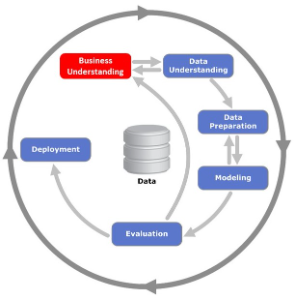

**Contexto:**

O Banco Prospex, instituição bancária portuguesa, deseja melhorar sua eficácia nas campanhas de marketing para depósitos bancários a prazo. Para atingir esse objetivo, você deve desenvolver um modelo preditivo capaz de prever a propensão dos clientes à subscrição desse produto.

<br>

**Descrição do Problema:**

O problema em questão é a falta de direcionamento eficiente nas campanhas de marketing para depósitos bancários a prazo. Atualmente, a abordagem de marketing é ampla e pouco personalizada, o que resulta em baixas taxas de conversão e uso ineficaz de recursos.

<br>

**Desafio de Negócio:**

Seu desafio é criar um modelo de propensão de compra de depósito bancário a prazo que permita à instituição prever quais clientes têm maior probabilidade de adquirir esse produto. O objetivo é:

* Desenvolver um modelo de aprendizado de máquina capaz de prever a propensão de um cliente à subscrição do produto com base em seus atributos e histórico.

* Identificar os principais fatores que influenciam a decisão dos clientes de subscreverem ou não um depósito bancário a prazo com base nas informações disponíveis.

* Utilizar o modelo para classificar os clientes em grupos de alta, média e baixa propensão, permitindo que a equipe de marketing direcione seus esforços de maneira mais eficaz.

* Aumentar a taxa de conversão das campanhas de marketing, economizando recursos e melhorando o retorno sobre o investimento.

<br>

**Ganhos esperados com o projeto:**

* Captação de Recursos: Os depósitos a prazo permitem que o banco capte recursos de clientes, que são usados para financiar operações e empréstimos.

* Fonte de Financiamento de Baixo Custo: Os depósitos a prazo são uma fonte de financiamento relativamente barata para o banco, pois eles geralmente oferecem taxas de juros menores aos clientes do que as taxas cobradas em empréstimos.

* Aumento da Base de Clientes: Oferecer depósitos a prazo pode atrair novos clientes para o banco, expandindo sua base de clientes e potencialmente aumentando a participação de mercado.

* Diversificação de Fontes de Financiamento: Os depósitos a prazo ajudam o banco a diversificar suas fontes de financiamento, reduzindo a dependência de outras formas de captação de recursos, como empréstimos interbancários.

* Construção de Relacionamentos: Ao oferecer produtos como depósitos a prazo, o banco pode construir relacionamentos mais duradouros com os clientes, o que pode levar a vendas cruzadas de outros produtos financeiros.

* Gestão de Liquidez: Os depósitos a prazo também ajudam na gestão da liquidez do banco, fornecendo uma fonte de financiamento estável e de longo prazo.

<br>

**Definição do público:**

O banco possui o interesse em realizar oferta dos serviços para o público entre 25 e 65 anos.

<br>

**Faixas de Score para Propensão:**

As faixas de score para classificar a propensão dos clientes podem ser definidas da seguinte maneira:

* Alta Propensão: Score acima de 0.75
* Média Propensão: Score entre 0.5 e 0.75
* Baixa Propensão: Score abaixo de 0.5

<br>

**Implantação do modelo:**

O modelo deverá ser implantando através de uma API que será consumida online.
As equipes de marketing/vendas, ao realizar campanhas, terão acesso à uma página web ao qual haverá um botão de upload do conjunto de dados disponíveis no momento, e como retorno deverão obter 3 planilhas, separadas de acordo com o score dos clientes. Porém, o banco possui recursos limitados em relação à infraestrutura em nuvem, por isso, o menor custo computacional deve ser considerado.

<br>

**Métricas de Avaliação:**

Para medir o desempenho do modelo, consideraremos as seguintes métricas:

* **AUC-ROC:** É a área sob a curva ROC, que é um gráfico do Recall versus 1 - Especificidade para diferentes pontos de corte. Um modelo perfeito terá AUC = 1, enquanto um modelo aleatório terá AUC = 0.5. Não possui uma fórmula única, sendo geralmente calculada por métodos numéricos.


* **Índice Gini:** é uma métrica derivada da AUC-ROC e é utilizada para quantificar a desigualdade ou impureza de um modelo de classificação.
Índice Gini=2×AUC−1


* **Estatística KS (Kolmogorov-Smirnov):** é a diferença máxima entre as funções de distribuição acumulada de eventos e não eventos, avaliando assim a capacidade de discriminação do modelo. Não possui uma fórmula única, sendo geralmente derivada a partir da análise da distribuição acumulada das probabilidades previstas.

<br>

Abaixo estão as definições de termos comumente utilizados na avaliação de modelos de clasificação binária:

* **Verdadeiro Positivo (VP ou TP - True Positive):** Refere-se ao número de casos em que o modelo previu corretamente a classe positiva. Ou seja, tanto a previsão do modelo quanto o valor verdadeiro são positivos.

* **Falso Positivo (FP ou FP - False Positive):** Refere-se ao número de casos em que o modelo previu incorretamente a classe positiva. Ou seja, a previsão do modelo é positiva, mas o valor verdadeiro é negativo. Também é conhecido como "Erro Tipo I" ou "Falso Alarme".

* **Verdadeiro Negativo (VN ou TN - True Negative):** Refere-se ao número de casos em que o modelo previu corretamente a classe negativa. Ou seja, tanto a previsão do modelo quanto o valor verdadeiro são negativos.

* **Falso Negativo (FN ou FN - False Negative):** Refere-se ao número de casos em que o modelo previu incorretamente a classe negativa. Ou seja, a previsão do modelo é negativa, mas o valor verdadeiro é positivo. Também é conhecido como "Erro Tipo II" ou "Perda".

<br>

**Dados Disponíveis:**

Será disponibilizado um conjunto de dados completo que inclui informações demográficas dos clientes, dados financeiros, histórico de contatos anteriores e resultados de campanhas de marketing anteriores.

---

#Data Understanding

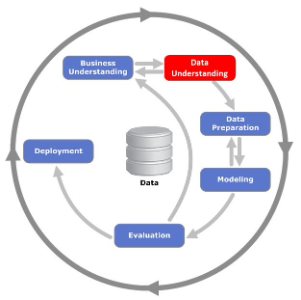

##Fonte de dados

Os dados podem ser acessados através o link: www.kaggle.com/datasets/henriqueyamahata/bank-marketing

##Dicionário de dados

**Variáveis explicativas:**

* Age: idade - numérica

* Job: tipo de emprego - categórica

* Marital : estado civil - categórico; obs: «divorciado» significa divorciado ou viúvo

* Education: escolaridade - categórica

* Default: tem crédito inadimplente? - categórica

* Housing: tem crédito habitação? - categórica

* Loan: tem empréstimo pessoal? - categórica

* Contact: tipo de comunicação de contato - categórica

* Month: último mês de contato do ano - categórica

* Day_of_week: último dia de contato da semana - categórica

* Compaign: quantidade de ligações foram feitas para o cliente nesta campanha - numérica

* Pdays: número de dias que se passaram após última ligação para o cliente em uma campanha anterior - numérica; 999 significa que o cliente não foi contatado anteriormente

* Previous: quantidade de ligações realizadas para o cliente antes desta campanha - numérica

* Poutcome: resultado da campanha de marketing anterior - categórica

* Emp.var.rate: taxa de variação do emprego - indicador trimestral - numérica

* Cons.price.idx: índice de preços no consumidor - indicador mensal - numérica

* Cons.conf.idx: índice de confiança do consumidor - indicador mensal - numérica

* Euribor3m: taxa euribor a 3 meses - indicador diário - numérica

* Nr.employed: número de empregados - indicador trimestral - numérica

* Duration: duração do último contato, em segundos - numérico; Observação importante: esse atributo afeta fortemente a target (por exemplo, se
duration=0 e y='no'). No entanto, a duração não é conhecida antes de uma chamada
ser realizada. Além disso, após o fim da chamada y é obviamente conhecido.
Assim, essa variável só deve ser incluída para fins de benchmark e
deve ser descartado se a intenção for ter um modelo preditivo realista.

<br>

**Target:**
* y: cliente subscreveu um depósito a prazo? - binário: 'sim', 'não'

<br>

>Observação: para conjunto de dados com uma grande quantidade de variáveis explicativas pode-se tornar inviável elaborar o dicionário de dados.

---

##Visualização dos dados

In [89]:
# Importação dos dados
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos pessoais/01. Projetos Machine Learning/Feature selection - estudo/bank-additional-full.csv' , sep=';')

# Dropando a feature 'Duration', conforme orientação do dicionário de dados
data.drop('duration' , axis=1 , inplace=True)


# Limitação do público
data = data[(data['age']>= 25) & (data['age']<= 65)]


# Criando cópia dos dados
df=data.copy()

In [90]:
# Visualizando linhas aleatórias
df.sample(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
2816,56,unemployed,divorced,high.school,no,yes,no,telephone,may,wed,1,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,no
26578,55,entrepreneur,married,professional.course,no,yes,no,cellular,nov,thu,3,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no
14948,43,technician,married,high.school,no,no,no,cellular,jul,wed,7,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no


In [91]:
# Criando os metadados
df_report = report_data(df)
df_report


  Quantidade de linhas duplicadas: 1727  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 9  |  Quantidade de features categóricas 11
  Cardinalidade total das categóricas: 55  |  Dataframe: 39501 linhas, 20 colunas
        


,Feature,Tipo,Card,%Miss,%Out_sup,%Out_inf,%Outliers,Moda,%Freq
0,age,int64,41,0.0,0.0,0.0,0.0,31.0,4.9
1,job,object,12,0.0,0.0,0.0,0.0,admin.,26.0
2,marital,object,4,0.0,0.0,0.0,0.0,married,61.7
3,education,object,8,0.0,0.0,0.0,0.0,university.degree,30.2
4,default,object,3,0.0,0.0,0.0,0.0,no,78.5
5,housing,object,3,0.0,0.0,0.0,0.0,yes,52.3
6,loan,object,3,0.0,0.0,0.0,0.0,no,82.4
7,contact,object,2,0.0,0.0,0.0,0.0,cellular,62.7
8,month,object,10,0.0,0.0,0.0,0.0,may,34.0
9,day_of_week,object,5,0.0,0.0,0.0,0.0,thu,20.9


Através do dataframe acima podemos extrair algumas informações que podem nos ajudar a entendendimento dos dados com foco no modelo:

* 5 variáveis explicativas não estão relacionadas aos indivíduos: 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx' e 'euribor3m'.

* A target (y) está em formato 'object' e suas saídas precisarão ser convertidas em valores binários.

* Ainda para a Target, existe um certo nível de desbalanceamento em sua distribuição: 89,6% dos indivíduos não subscreveram um empréstimo de longo prazo.

* Existem 1727 linhas duplicadas e que não serão removidas pois entende-se que cada linha (ou indivíduo) é de suma importância para o desempenho do modelo.

* Considerando todas as variáveis categoricas (11 features), e desconsiderando a target (2 categorias), teremos 55 - 11 - 2 = 42 novas colunas criadas no dataframe caso queiramos utilizar variáveis dummies para codificar estas features. Assim, o dataset final teria 42 + 9 = 51 variáveis explicativas. Dessa forma, não há nenhum problema causado pelo aumento da dimensionalidade, visto a grande quantidade de linhas no dataset (proporção de 53 colunas para 41188 linhas)


#Data Preparation


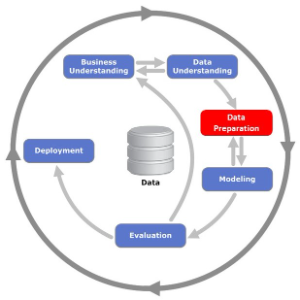

Na preparação dos dados, serão realizadas as seguintes etapas:


* Limitação do público entre 25 e 65 anos

* Codificação da target categórica para target binária

* Features com percentual de nulos acima de 80% serão removidas

* Features numéricas terão seus valores missing preenchidos com a **moda**

* Features categóricas terão seus valores missing preenchidos com a **moda**

* Codificação das variáveis categóricas, onde as features com cardinalidade acima de 7 será aplicado o LabelEncoder e para cardinalidade menor ou igual a 7, o OneHotEncoder (criação de dummies)

<br>

Para automação do processo, grande parte da etapa de preparação dos dados será realizada através função que realiza as tarefas de codificação, imputação e dropagem de features. Além disso, esta função já aplica a validação cruzada Holdout, separando 30% dos dados para teste.

Após a preparação da conjunto de dados, será realizada uma rodada de Feature Selection, com o intuito de eliminar features que não agregam ao modelo. Nesta etapa outra função será responsável pelo processo.

<br>

Após a etapa de modelagem, será avaliada a necessidade de se retornar a esta etapa (DataPreparation)

In [92]:
# Preparação dos dados - chamando a função
A = dataprep(df,'y', df_report, lim_miss=80 , lim_card=7, scaled='all' , encoder_method = 'onehot+label', convert_target='yes', stratify='yes')

#df: Dataframe base
#'y': Target
#df_report: metadados, auxiliar
#lim_miss: limite para dropagem de features por quantidade de missig
#lim_card: limite de cardinalidade. Abaixo disso, aplica OneHotENcoder, acima aplica LabelEncoder (quando 'encoder_method='onehot+label)
#scaled: Aplica padronização em todos os dados ou somente nas variáveis originalmente numéricas -- 'all' / 'num'
#encoder_method: método de codificação - 'onehot+label' / 'catboost'
#convert_target: converte a target em binária -- 'yes' / 'no'
# stratify: faz o split de traino e test estratificado pela target? -- 'yes' / 'no'

In [93]:
# Restaurando os dados de treino (redução do nome para facilidade)
X_train = A.X_train_enc
y_train = A.y_train

X_test = A.X_test_enc
y_test = A.y_test

##Feature selection

A etapa de Feature Selection será realizada com o intuito de reduzir o número de variáveis do modelo. Isto traz benefícios como a redução de dados ruidosos e sem importância nas predições e ganho de performance computacional no processamento. Nesta etapa, iniciaremos fazendo um corte na importância das features igual a 40% da maior importância encontrada.

In [94]:
# Juntando dados de treino e teste tratados
# Nesta etapa não há necessidade de separação em treino e teste

X = pd.concat([X_train, X_test], axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Validação do empilhamento
a=X_train.shape
b=X_test.shape
c=X.shape
print(a, b, c)

(27650, 28) (11851, 28) (39501, 28)



Features removidas: 23
Features remanescentes: 5



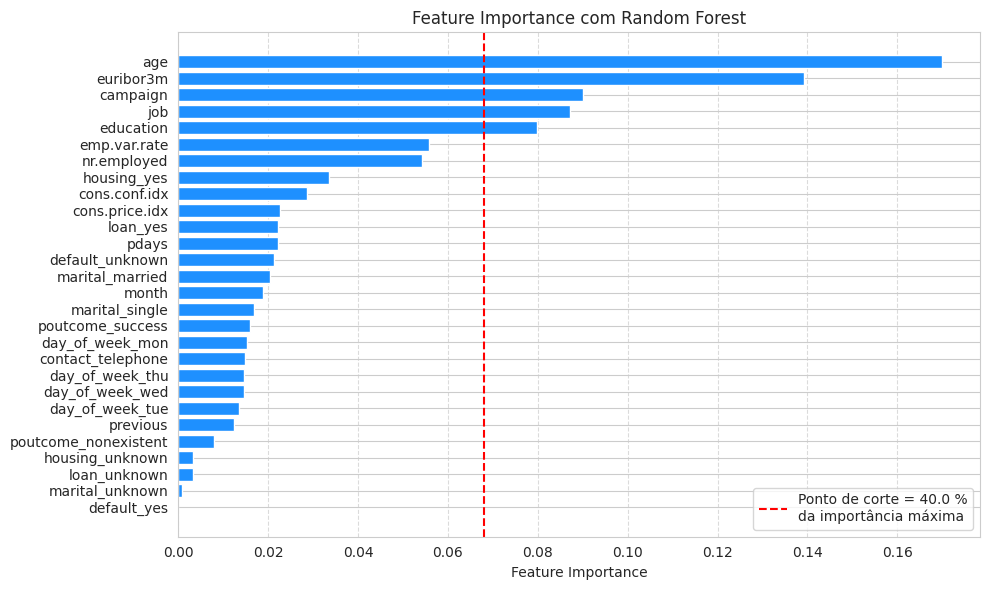

In [95]:
# Calculando e visualizando a Feature Importance
lista_fs_importance = fs_importance(X , y , cutoff_importance = 0.4, plot=True)

In [96]:
# Lista de features seleciondas
lista_fs_importance

['age', 'job', 'education', 'campaign', 'euribor3m']

Avaliando o gráfico, percebe-se que as features 'age' e 'euribor3m' possuem os maiores valores de importância e estão isoladas em relação às demais, indicado que o modelo pode ficar refém destas duas features. Porém, antes de serem tomadas medidas de reavaliação de Feature Importance, o modelo será treinado e testado para que se possa verificar suas métricas e a real necessidade de ajustar a lista de features seleciondas.

Pelo gráficos, podemos ter uma ideia geral de que as features seleciondas podem fazer sentido do ponto de vista de explicabilidade do modelo:
* **age:** faz sentido em ser importante para a aquisição do produto bancário

* **euribor3m:** faz sentido por ser um indicador econômico

* **campaing:** não é possível afirmar que a quantidade de ligações realizadas pode influenciar na decisão de aquisiçãodo produto bancário.

* **job:** faz sentido por ser um dos principais indicadores de renda do indivíduo, o que pode determinar se uma pessoa tem renda sufuciente para investimentos ou não

* **education:** faz sentido e pode estar correlacionada à feature job.

In [97]:
# Ajustando a tabela analítica de modelagem com as features selecionadas

# Restaurando somente as features selecionadas e o target
df = data[lista_fs_importance +['y']].copy()

In [98]:
# Gerando novo report
df_report = report_data(df)


  Quantidade de linhas duplicadas: 9729  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 3  |  Quantidade de features categóricas 3
  Cardinalidade total das categóricas: 22  |  Dataframe: 39501 linhas, 6 colunas
        


In [99]:
# Gerando novo dataprep
B = dataprep(df,'y', df_report, lim_miss=80 , lim_card=7, scaled='all' , encoder_method = 'onehot+label', convert_target='yes', stratify='yes')

# Restaurando os dados de treino e teste
# Redução do nome para facilidade
X_train = B.X_train_enc
X_test = B.X_test_enc
y_train = B.y_train
y_test = B.y_test

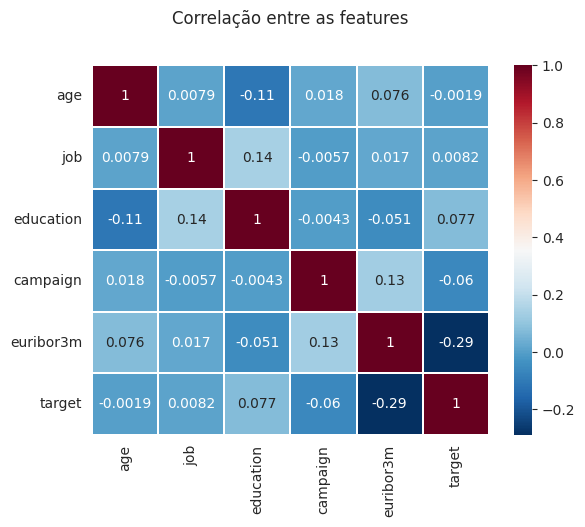

In [100]:
# Verificando a correlação entre as variáveis selecionadas
df_aux = X_train.copy()
df_aux['target'] = y_train

sns.heatmap(df_aux.corr(), annot=True, linewidth=0.2, cmap='RdBu_r')
plt.title('Correlação entre as features' , pad=30)
_=plt.show()

Não existem variáveis altamente correlacionadas, indicando que o processo de Feature Selection foi adequado.

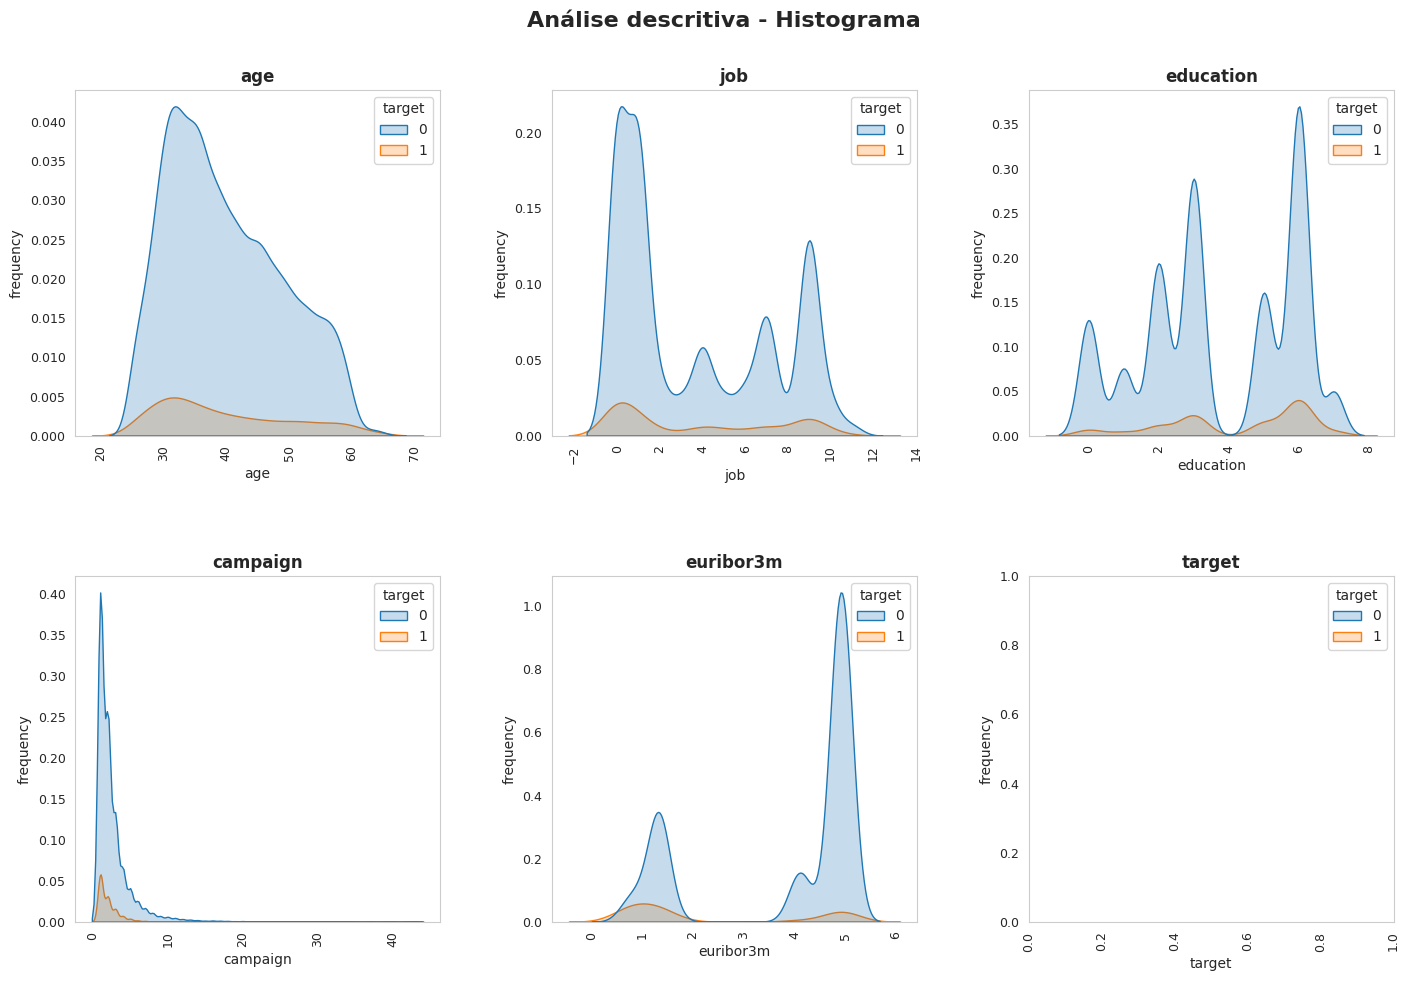

In [101]:
# Visualizando a dstribuição das features selecionadas em relação à target
plot_batch_histogram(df_aux, cols=3, hue='target')

Conforme os gráficos acima, é possível visualizar que todas as variáveis são capazes de segregar "evento" de "não-evento".

#Modeling

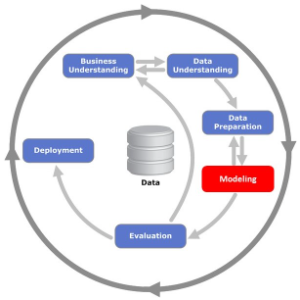

Como base nas informações do 'Business Understanding' optaremos por utilizar um modelo de Floresta Aleatória (RandomForest). Esta escolha se baseia no seguinte:

* É um modelo que traz certa explicabilidade, atendendo à necessidade do negócio em saber os fatores que mais influenciam a propensão de adesão aos serviços ou não por parte dos clientes

* É um modelo com boa capacidade de predição, se tratando de um ensemble do tipo bagging

* É um modelo de baixo custo computacional, o que favorece a sua implantação online, tornando o processo rápido para o usuário final ao ser feita a chamada da API

* Sendo um modelo de baixo custo computacional, garante-se o menor impacto possível na infraestrutura existente.

##Modelo baseline

In [102]:
# Intanciando o modelo DecisionTree
rf = RandomForestClassifier(random_state=42)

# Treinando o modelo
rf.fit(X_train, y_train)

# Previsões nos dados de treino
y_train_pred = rf.predict(X_train)
y_train_pred_prob = rf.predict_proba(X_train)

# Previsões nos dados de teste
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)

In [103]:
# Tabela de métricas - DecisionTree
df_metrics_rf = calculate_metrics('DecisionTree - baseline', rf, X_train, y_train, X_test, y_test)

# Exibindo
df_metrics_rf

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTree - baseline,Treino,0.976637,0.954918,0.812980,0.995671,0.991343,0.937888
1,DecisionTree - baseline,Teste,0.885495,0.407989,0.232899,0.725978,0.451956,0.385415


Analisando a tabela de resultados das métricas acima, percebe-se claramente a ocorrência de overfiting. A alta performance do modelo ao predizer os dados de treino indicam que o modelo encontrou padrões até mesmo nos ruídos destes dados, e não é capaz de generalizar as predições para os dados de teste.

##Modelo tunado

In [104]:
# Instanciando
rf = RandomForestClassifier(random_state=42)

# Criando o grid de hiperparâmetros
grid_param = {
      'criterion': ['gini','entropy'],
      'max_depth': [3,5],                     # Profundidade máxima da árvore
      'min_samples_split': [1,2,5],           # Número mínimo de amostras necessárias para dividir um nó interno.
      'min_samples_leaf': [1,2,5],            # Número mínimo de amostras necessárias para estar em um nó folha.
      'class_weight': [None, 'balanced']}     # Balanceamento das classes

# Chamando o GridSearch
grid = GridSearchCV(rf, grid_param, cv=5, scoring='roc_auc', n_jobs=-1)  # 'accuracy' 'precision' 'recall' 'f1'

# Treinando o modelo com GridSearch
grid.fit(X_train, y_train)

# Obtendo o melhor modelo
rf_opt = grid.best_estimator_

In [105]:
# Melhor score encontrado
print(f'roc_auc = {grid.best_score_}')

roc_auc = 0.7664229077213184


In [106]:
# Visualizando os melhores hiperparâmetros
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [107]:
# Calculando e visualizando as métricas
df_metrics_rf_opt = calculate_metrics('RandomForest tunado', rf_opt, X_train, y_train, X_test, y_test)
df_metrics_rf_opt

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForest tunado,Treino,0.787342,0.275142,0.643405,0.787536,0.575072,0.454941
1,RandomForest tunado,Teste,0.783141,0.267820,0.630293,0.764894,0.529789,0.432529


Agora, as métricas obtidas com as predições nos dados de treino estão muito próximas das predições nos dados de teste, o que indica que o modelo está adequado para ser avaliado e colocado em produção, caso não seja solicitada nenhuma intervenção pela equipe de negócio.

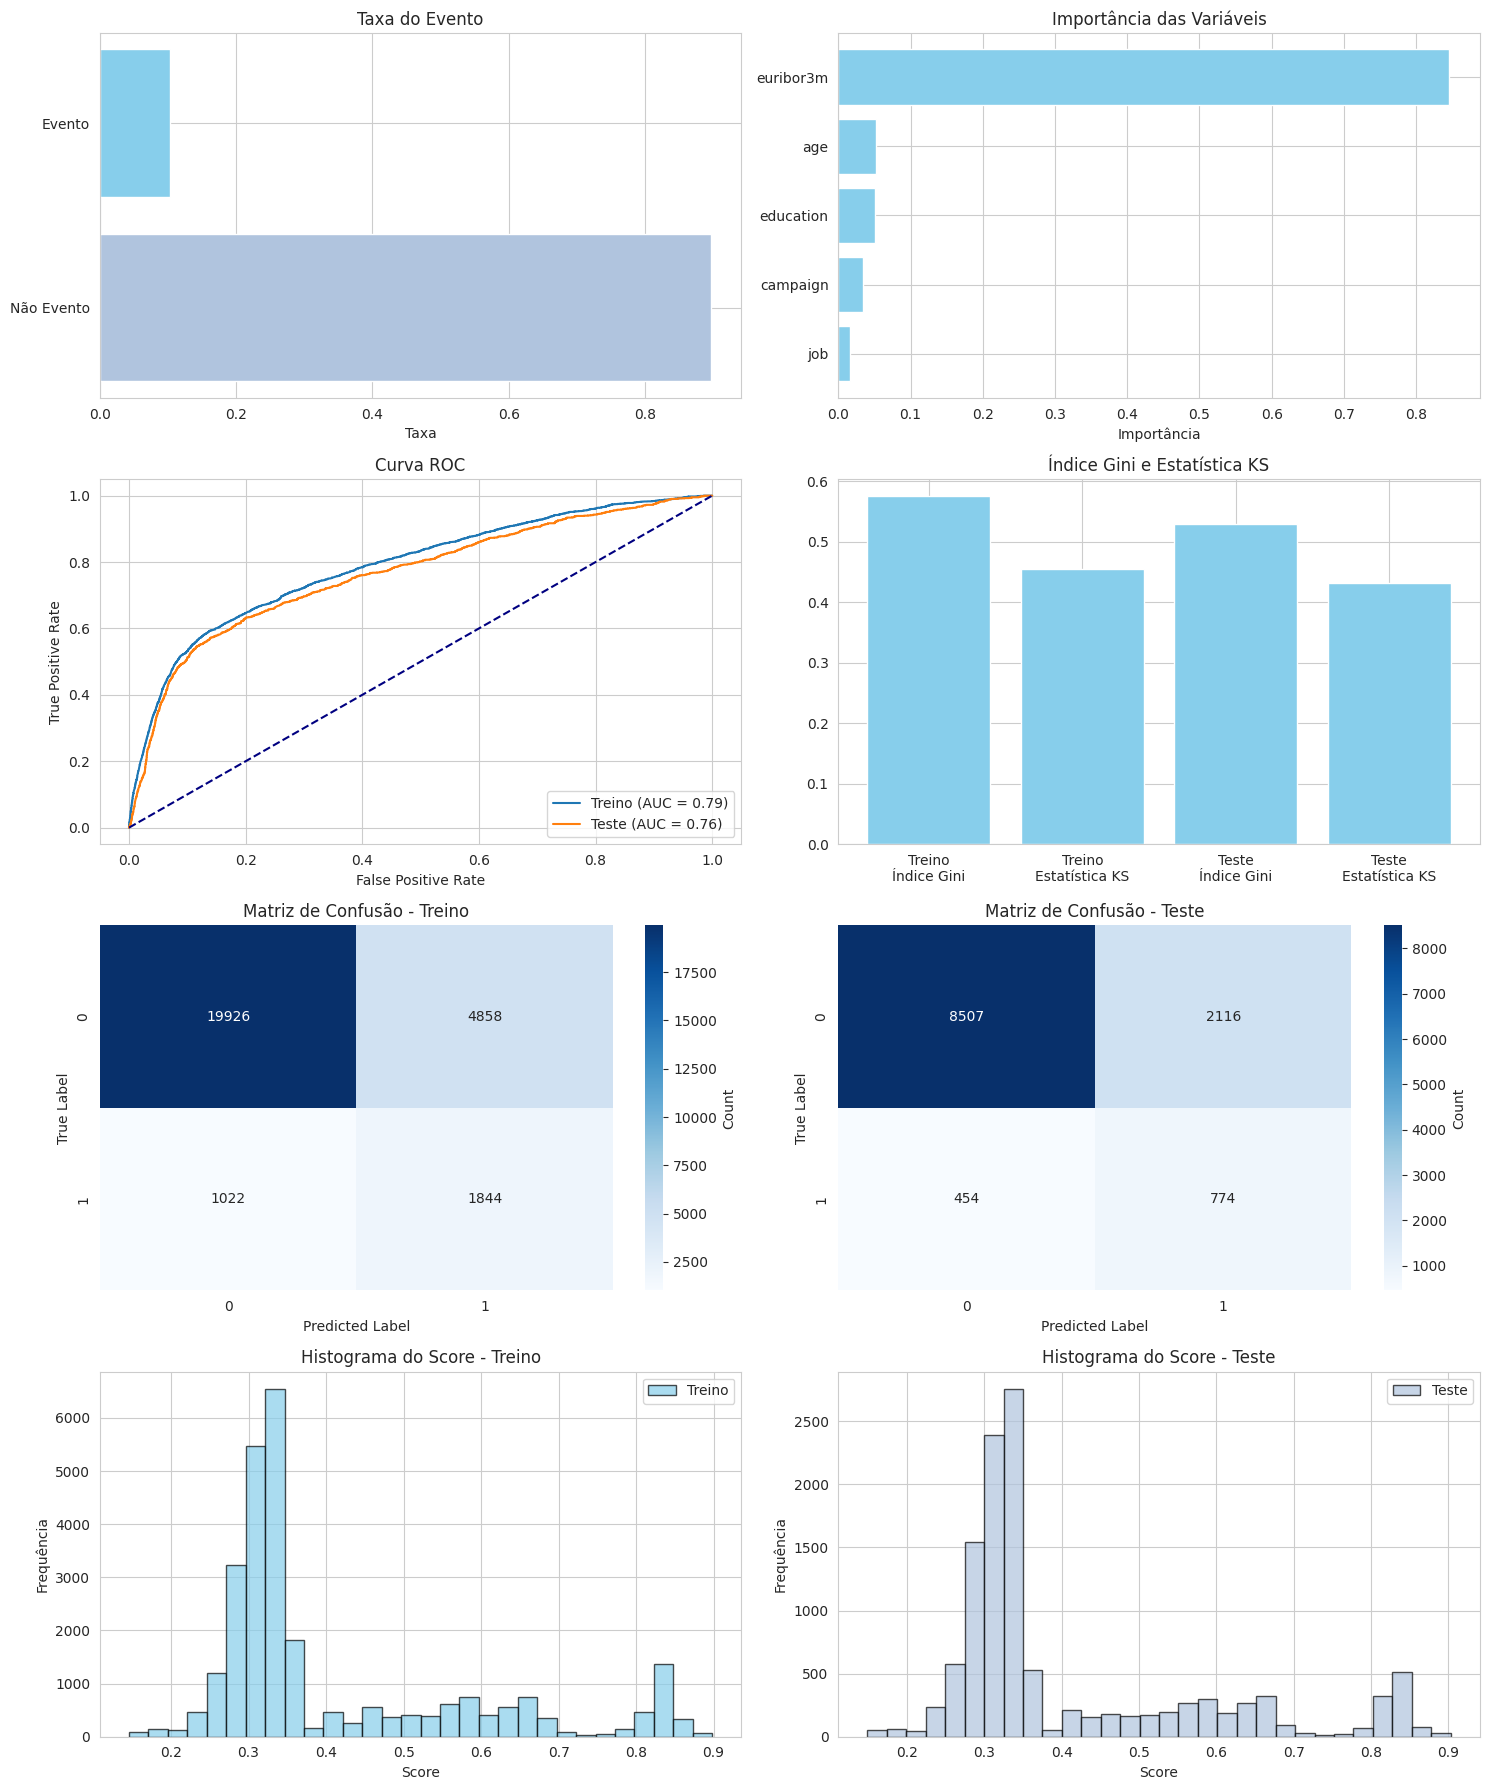

In [108]:
# Visualizando as métricas
plot_metrics(rf_opt, X_train, y_train, X_test, y_test)

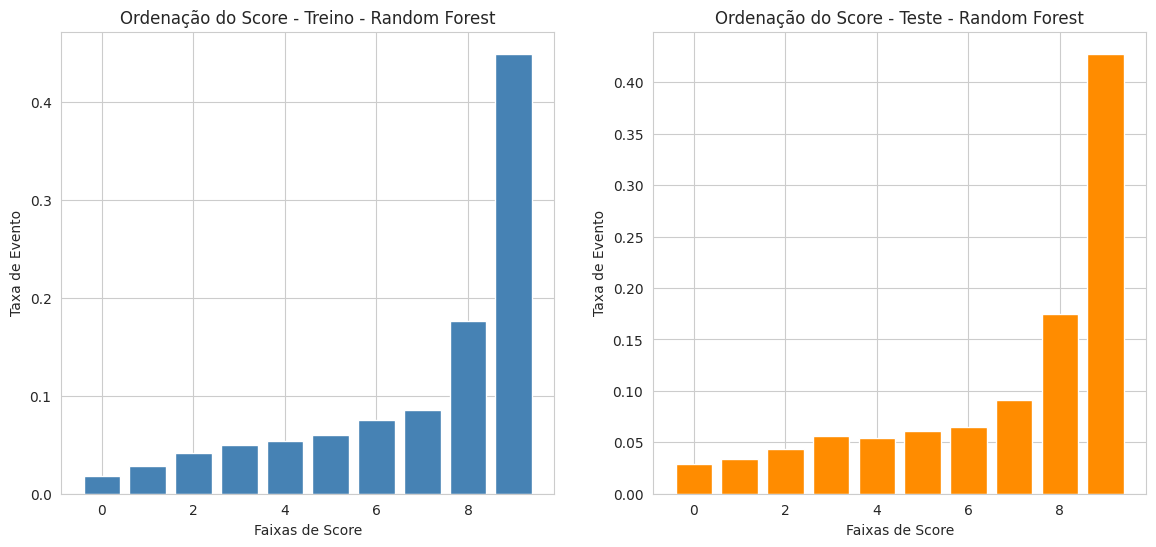

In [109]:
# Ordenação dos scores
ordena_score(rf_opt, 'Random Forest', X_train, X_test, y_train, y_test)

#Evaluation

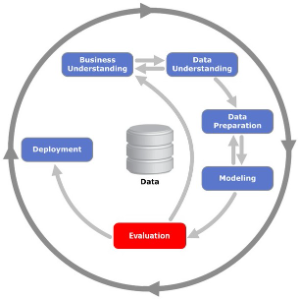

Nesta etapa será feita a avaliação do modelo junto com o time de negócios. Caso o modelo seja validado, serão extraídos os artefatos utilizados para que seja realizado o deploy. Caso haja alguma inconsistência seja identificada, reavaliaremos as etapas anteriores (Business Understanding, Data Understanding, Data Preparation e Modeling) com o intuito de tornar o modelo mais alinhado com o negócio.

<br>

**Taxa de evento:**

  Mantém a proporção do conjunto de dados inicial, que é de aproximadamente 10.4% de evento (saída de target igual a 1 - prepensão à compra)

<br>

**Importância das variáveis:**

Após o treinamento do modelo com tunagem de hiperparâmetros, a feature 'euribor3m' assumiu a maior relevância dentre as features selecionadas na etapa de Feature Selection.

Isto indica que que as predições serão altamente influenciadas por esta variável, o que não é interessante para a equipe de negócios pois o modelo fica dependente somente desta variável.

Quaisquer variações anômalas em seus valores poderiam acarretar em perda de desempenho do modelo. Além disso, esta variável é um indicador econômico, e não uma característica direta ou indiretamente ligada ao indivíduo.

Sendo assim, dada a alta relevância que a feature 'euribor3m' obteve no modelo, a equipe de negócio optou em não prosseguir com essa feature na modelagem.

<br>

**Métricas do modelo nos dados de teste**:
Os valores das principais métricas de avaliação do modelo são:
* AUC-ROC: 0.76
* Gini: 0.53
* KS: 0.43

Os valores estão satisfatórios do ponto de vista do negócio.


<br>

**Matriz de confusão**:

O modelo está comentendo menos erros em relação aos falsos negativos do que em relação aos falsos positivo. Isto é vantajoso pois há a necessidade de se priorizar exatamente as predições da classe positiva. Ou seja, o modelo erra menos ao tentar predizer a classe 1 (evento=propensão=yes) do que a classe 0 (não evento = não propensão = no)

<br>

**Ordenação do score**:
Os scores possuem ordenação visível para os dados de treino. Porém, para os dados de teste, a taxa de crescimento dos scores é muito baixa nas primeiras classes, o que pode estar ocorrendo por conta de desbalanceamento dos dados, insuficiência de características, etc.


---




#Data Preparation


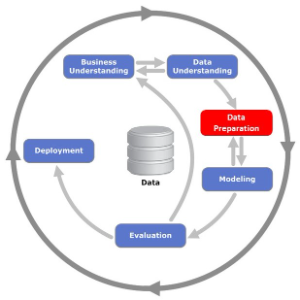

Retornando a esta etapa para remoção da feature 'euribor3m' que representa um indicador enconômico e que assumiu toda a importância do modelo.


> NOTA: não seria necessário criar novos código para estes ajustes. Bastaria ajustar diretamente no código inicial.
Optou-se por duplicar este trecho para a sequência de racicínio fique registrada.



In [110]:
# Restaurando os dados
df = data.copy()

# Excluindo as features de indicadores econômicos
list_del = ['euribor3m']
df.drop(list_del, axis=1, inplace=True)

In [111]:
# Visualizando
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no


In [112]:
# criando os matadados
df_report = report_data(df)


  Quantidade de linhas duplicadas: 2296  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 8  |  Quantidade de features categóricas 11
  Cardinalidade total das categóricas: 55  |  Dataframe: 39501 linhas, 19 colunas
        


In [113]:
# Preparação dos dados - chamando a função
C = dataprep(df,'y', df_report, lim_miss=80 , lim_card=7, scaled='all' , encoder_method = 'onehot+label', convert_target='yes', stratify='yes')


Neste ponto vale ressaltar um erro que aconteceu ao tentar gerar uma nova preparação de dados: A feature 'default' possui apenas três ocorrências da categoria 'yes', e estas ocorrências foram todas agregadas nos dados de teste. Assim, após o trainamento do OneHotEncoder nos dados de treino, ao aplicar a transformação nos dados de teste ocorria um erro, pois a categoria "yes" não foi incluida no treinamento. Para contornar este erro foi alterada a semente de inicialização aleatória dentro da fução de Dataprep, ajustando o parâmetro de "random_state = 42" para "random_state = 1", da função "train_test_split"

      print(f'''
      Treino:
      {X_train['default'].value_counts()}
      Teste:
      {X_test['default'].value_counts()}''')


      Treino:
      no         21694
      unknown     5956

      Teste:
      no         9334
      unknown    2514
      yes           3


In [114]:
# Restaurando os dados de treino e teste (redução do nome para facilidade)
X_train = C.X_train_enc
y_train = C.y_train

X_test = C.X_test_enc
y_test = C.y_test

##Feature selection

In [115]:
# Juntando dados de treino e teste tratados
# Nesta etapa não há necessidade de separação em treino e teste

X = pd.concat([X_train, X_test], axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Validação do empilhamento
a=X_train.shape
b=X_test.shape
c=X.shape
print(a, b, c)

(27650, 27) (11851, 27) (39501, 27)



Features removidas: 23
Features remanescentes: 4



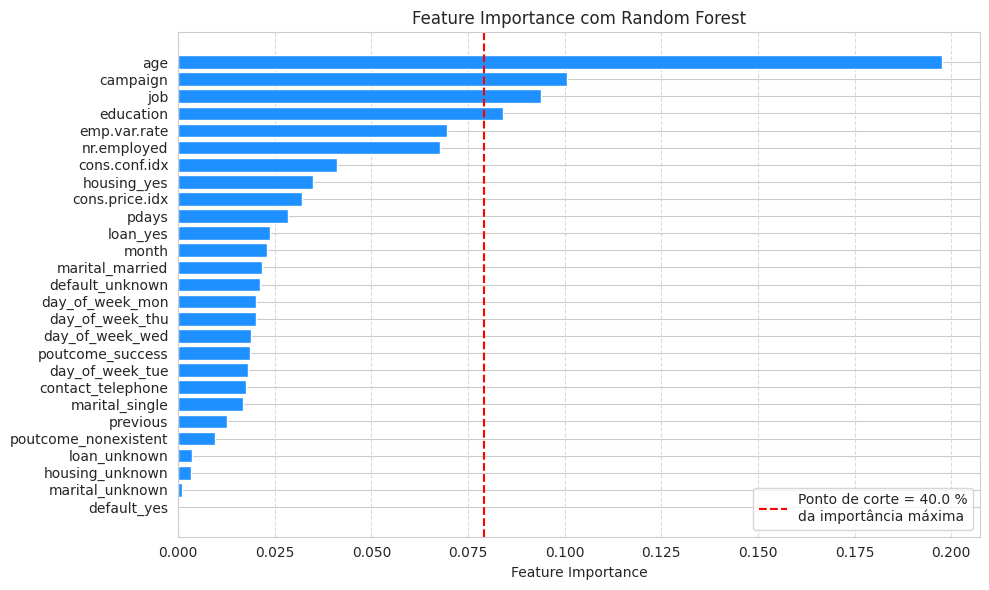

In [116]:
# Calculando e visualizando a Feature Importance
lista_fs_importance = fs_importance(X , y , cutoff_importance = 0.4, plot=True)

In [117]:
# Lista de features seleciondas
lista_fs_importance

['age', 'job', 'education', 'campaign']

In [118]:
# Ajustando a tabela analítica de modelagem com as features selecionadas

# Restaurando somente as features selecionadas e o target
df = data[lista_fs_importance +['y']].copy()

In [119]:
# Gerando novo report
df_report = report_data(df)


  Quantidade de linhas duplicadas: 29084  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 2  |  Quantidade de features categóricas 3
  Cardinalidade total das categóricas: 22  |  Dataframe: 39501 linhas, 5 colunas
        


In [120]:
# Gerando novo dataprep
D = dataprep(df,'y', df_report, lim_miss=80 , lim_card=7, scaled='all' , encoder_method = 'onehot+label', convert_target='yes', stratify='yes')

# Restaurando os dados de treino e teste
# Redução do nome para facilidade
X_train = D.X_train_enc
X_test = D.X_test_enc
y_train = D.y_train
y_test = D.y_test

#Modeling

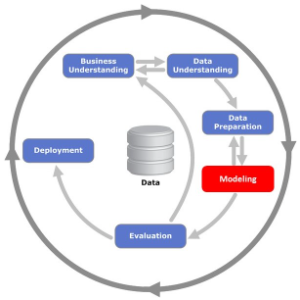

##Modelo tunado

In [121]:
# Instanciando
rf = RandomForestClassifier(random_state=42)

# Criando o grid de hiperparâmetros
grid_param = {
      'criterion': ['gini','entropy'],
      'max_depth': [3,5],                     # Profundidade máxima da árvore
      'min_samples_split': [1,2,5],           # Número mínimo de amostras necessárias para dividir um nó interno.
      'min_samples_leaf': [1,2,5],            # Número mínimo de amostras necessárias para estar em um nó folha.
      'class_weight': ['balanced'] }          # Balanceamento das classes

# Chamando o GridSearch
grid = GridSearchCV(rf, grid_param, cv=5, scoring='roc_auc', n_jobs=-1)  # 'accuracy' 'precision' 'recall' 'f1'

# Treinando o modelo com GridSearch
grid.fit(X_train, y_train)

# Obtendo o melhor modelo
rf_opt = grid.best_estimator_

In [122]:
# Melhor score encontrado
print(f'roc_auc = {grid.best_score_}')

roc_auc = 0.6238645223143824


In [123]:
# Visualizando os melhores hiperparâmetros
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [124]:
# Calculando e visualizando as métricas
df_metrics_rf_opt = calculate_metrics('RandomForest tunado', rf_opt, X_train, y_train, X_test, y_test)
df_metrics_rf_opt

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForest tunado,Treino,0.533852,0.139538,0.676902,0.640478,0.280956,0.197960
1,RandomForest tunado,Teste,0.527635,0.135955,0.664495,0.620908,0.241815,0.193869


As métricas obtidas nos conjuntos de treino e teste se aproximam, porém, tiveram redução em relação ao modelo anterior.

Será feita uma tentativa de melhoria do modelo através da flexibilização do ponto de corte de importâncias, com o intuito de permitir que mais variáveis possam ser selecionadas para a modelagem.


---



#Data Preparation


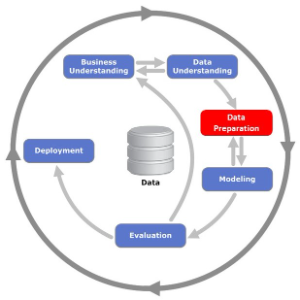

Retornando a esta etapa, agora o ponto de corte da Feature Selection será reduzido.

> NOTA: não seria necessário criar novos código para estes ajustes. Bastaria ajustar diretamente no código inicial.
Optou-se por duplicar este trecho para a sequência de raciocínio fique registrada.



In [125]:
# Restaurando os dados
df = data.copy()

# Excluindo as features de indicadores enconômicos
df.drop(list_del, axis=1, inplace=True)

In [126]:
# criando os matadados
df_report = report_data(df)


  Quantidade de linhas duplicadas: 2296  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 8  |  Quantidade de features categóricas 11
  Cardinalidade total das categóricas: 55  |  Dataframe: 39501 linhas, 19 colunas
        


In [127]:
# Preparação dos dados - chamando a função
E = dataprep(df,'y', df_report, lim_miss=80 , lim_card=7, scaled='all' , encoder_method = 'onehot+label', convert_target='yes', stratify='yes')


In [128]:
# Restaurando os dados de treino e teste (redução do nome para facilidade)
X_train = E.X_train_enc
y_train = E.y_train

X_test = E.X_test_enc
y_test = E.y_test

##Feature selection

In [129]:
# Juntando dados de treino e teste tratados
# Nesta etapa não há necessidade de separação em treino e teste

X = pd.concat([X_train, X_test], axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Validação do empilhamento
a=X_train.shape
b=X_test.shape
c=X.shape
print(a, b, c)

(27650, 27) (11851, 27) (39501, 27)



Features removidas: 18
Features remanescentes: 9



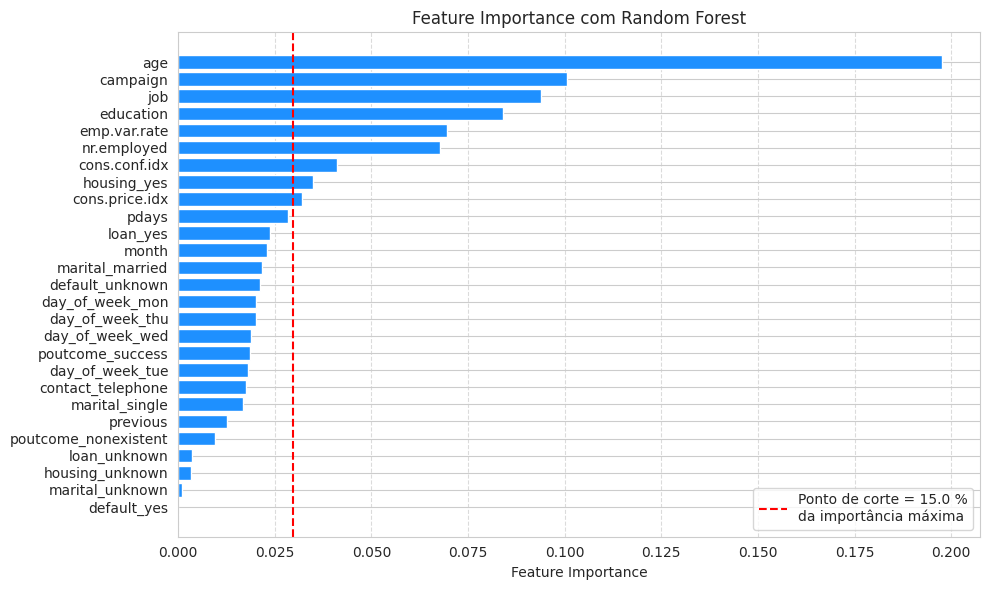

In [152]:
# Calculando e visualizando a Feature Importance
lista_fs_importance = fs_importance(X , y , cutoff_importance = 0.15, plot=True)

In [153]:
# Lista de features seleciondas
lista_fs_importance

['age',
 'job',
 'education',
 'campaign',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'nr.employed',
 'housing_yes']

In [154]:
# Ajustando a tabela analítica de modelagem com as features selecionadas

# Restaurando somente as features selecionadas e o target
df = data[['age','job','education','campaign','emp.var.rate','cons.price.idx',
 'cons.conf.idx','nr.employed','housing','y']].copy()

In [155]:
# Gerando novo report
df_report = report_data(df)


  Quantidade de linhas duplicadas: 13102  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 6  |  Quantidade de features categóricas 4
  Cardinalidade total das categóricas: 25  |  Dataframe: 39501 linhas, 10 colunas
        


In [156]:
# Gerando novo dataprep
F = dataprep(df,'y', df_report, lim_miss=80 , lim_card=7, scaled='all' , encoder_method = 'onehot+label', convert_target='yes', stratify='yes')

# Restaurando os dados de treino e teste
# Redução do nome para facilidade
X_train = F.X_train_enc
X_test = F.X_test_enc
y_train = F.y_train
y_test = F.y_test

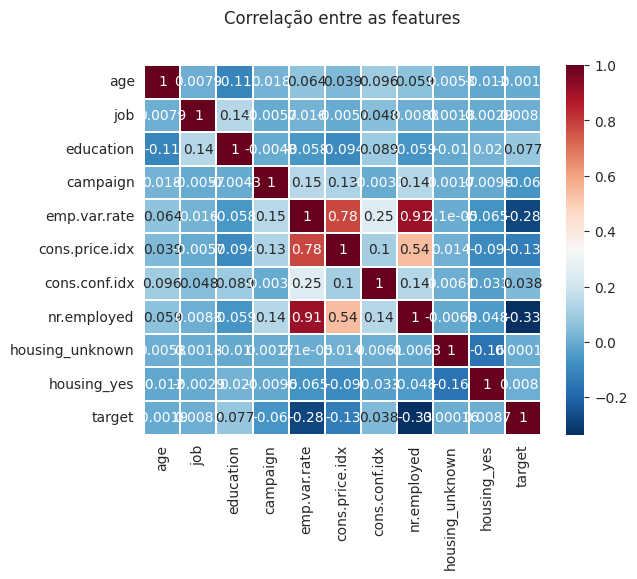

In [158]:
# Verificando a correlação entre as variáveis selecionadas
df_aux = X_train.copy()
df_aux['target'] = y_train


sns.heatmap(df_aux.corr(), annot=True, linewidth=0.2, cmap='RdBu_r')
plt.title('Correlação entre as features' , pad=30)
_=plt.show()

A feature 'emp.var.rate' possui alta correlação com as features 'cons.price.idx' e 'nr.employed'. Sendo assim, essa feature não será utilizada no modelo.

In [159]:
# Dropando a feature 'emp.var.rate'
lista_fs_importance.remove('emp.var.rate')
lista_fs_importance

['age',
 'job',
 'education',
 'campaign',
 'cons.price.idx',
 'cons.conf.idx',
 'nr.employed',
 'housing_yes']

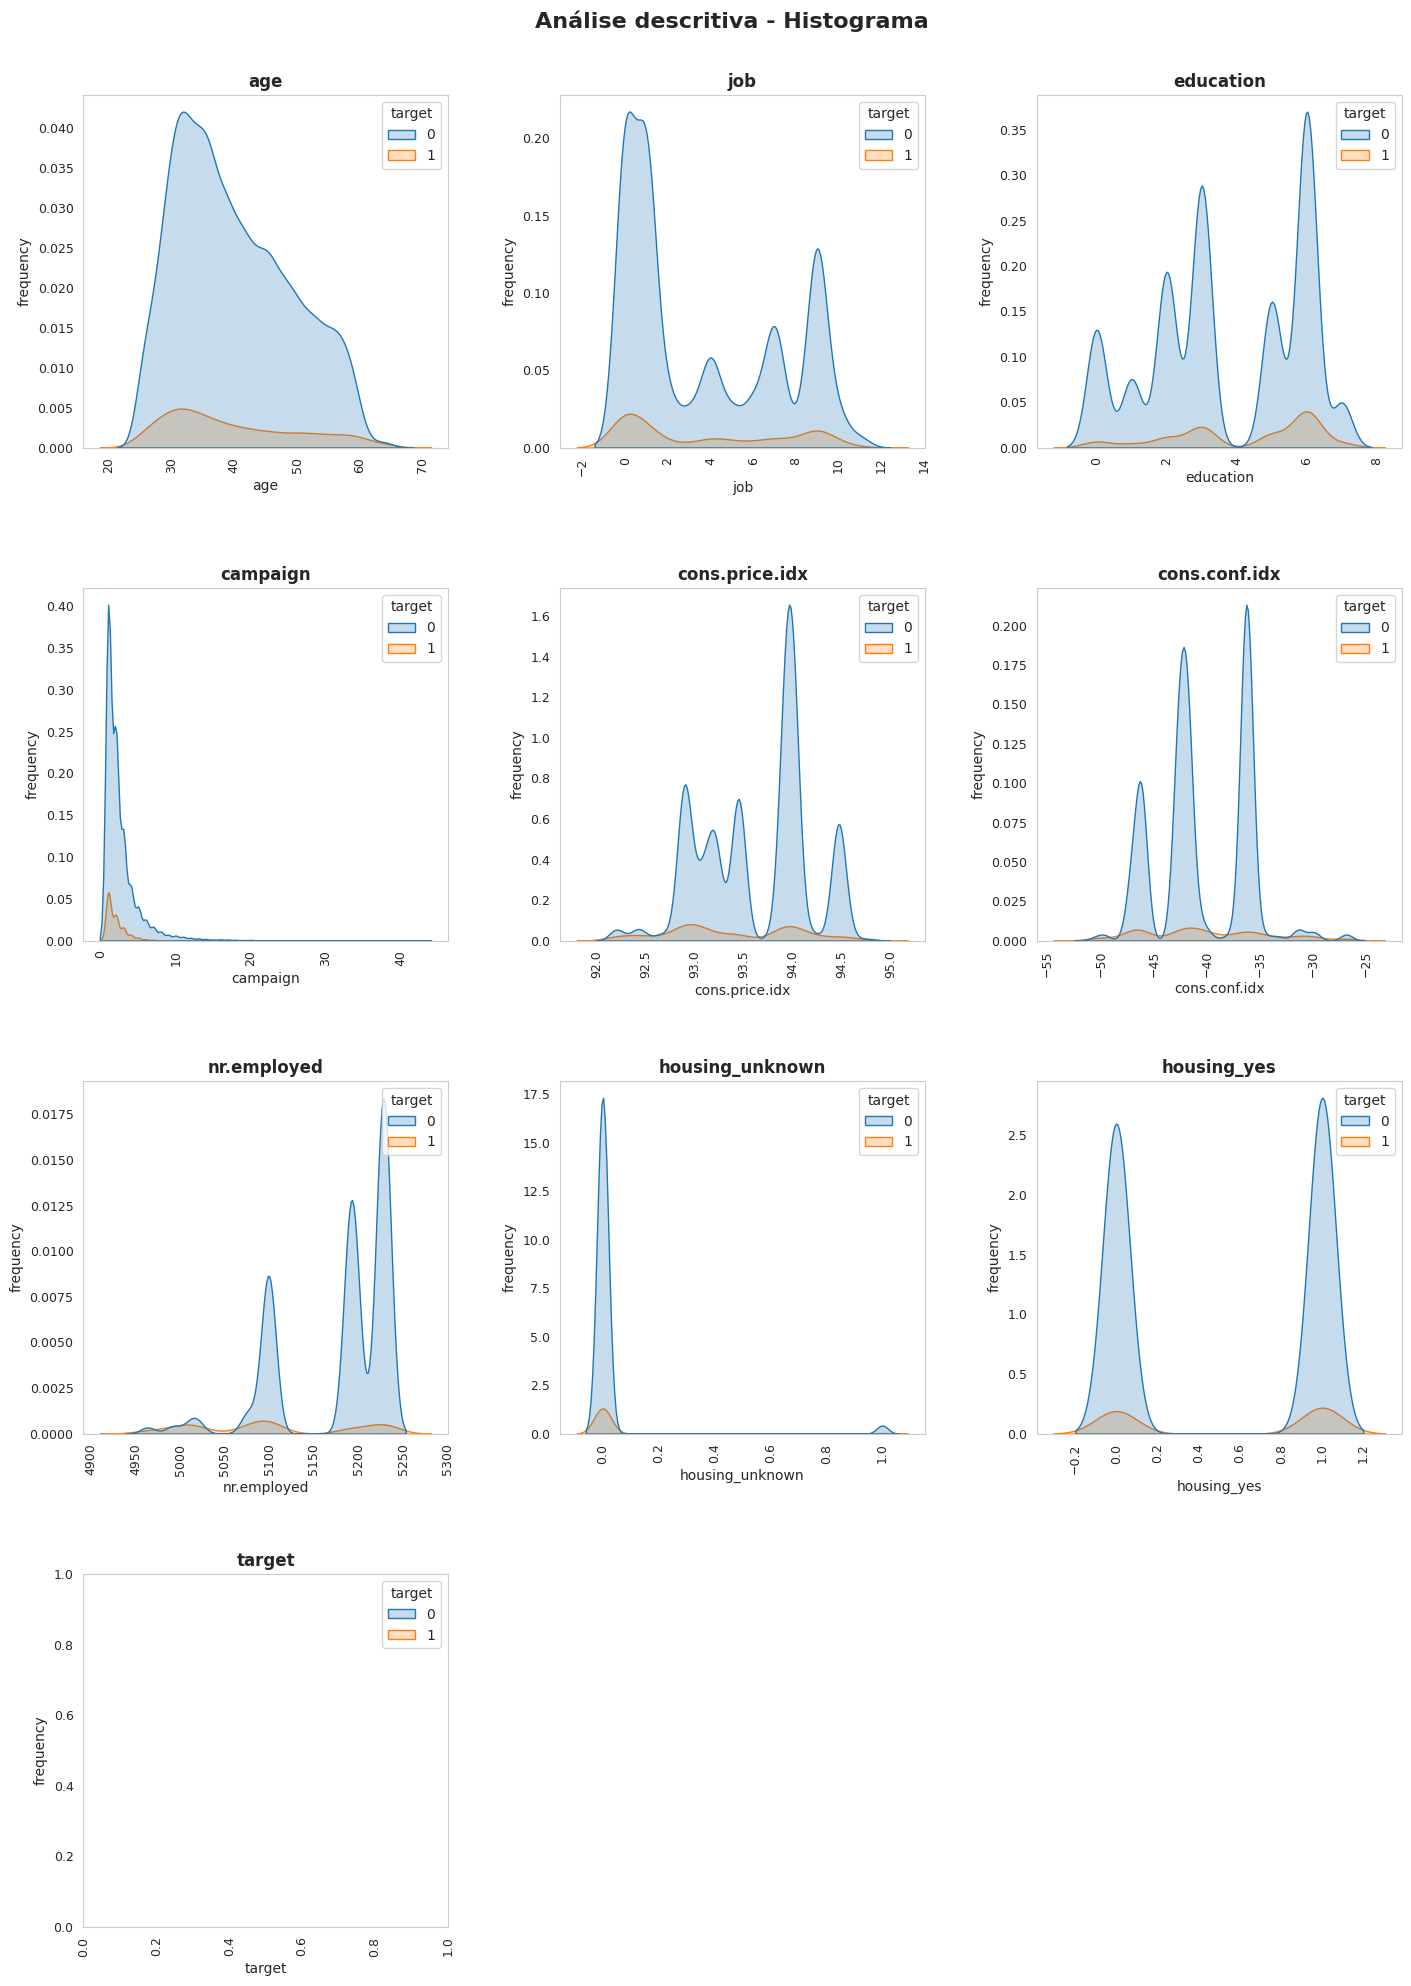

In [160]:
# Visualizando a dstribuição das features selecionadas em relação à target

df_aux.drop('emp.var.rate' , axis = 1 , inplace=True)

plot_batch_histogram(df_aux, cols=3, hue='target')

As novas features selecionadas também são efeicientes em segregar "evento" de "não-evento", de acordo com as distribuições acima.

#Modeling

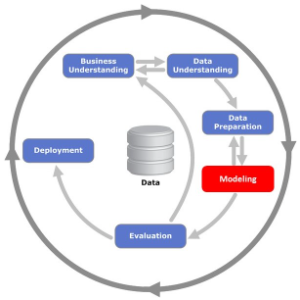

##Modelo tunado

In [161]:
# Instanciando
rf = RandomForestClassifier(random_state=42)

# Criando o grid de hiperparâmetros
grid_param = {
      'criterion': ['gini','entropy'],
      'max_depth': [3,5],                     # Profundidade máxima da árvore
      'min_samples_split': [1,2,5],           # Número mínimo de amostras necessárias para dividir um nó interno.
      'min_samples_leaf': [1,2,5],            # Número mínimo de amostras necessárias para estar em um nó folha.
      'class_weight': ['balanced'] }          # Balanceamento das classes

# Chamando o GridSearch
grid = GridSearchCV(rf, grid_param, cv=5, scoring='roc_auc', n_jobs=-1)  # 'accuracy' 'precision' 'recall' 'f1'

# Treinando o modelo com GridSearch
grid.fit(X_train, y_train)

# Obtendo o melhor modelo
rf_opt = grid.best_estimator_

In [162]:
# Melhor score encontrado
print(f'roc_auc = {grid.best_score_}')

roc_auc = 0.773640134641171


In [163]:
# Visualizando os melhores hiperparâmetros
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [166]:
# Calculando e visualizando as métricas
df_metrics_rf_opt = calculate_metrics('RandomForest tunado', rf_opt, X_train, y_train, X_test, y_test)
df_metrics_rf_opt

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForest tunado,Treino,0.794105,0.279863,0.627006,0.784105,0.568211,0.448685
1,RandomForest tunado,Teste,0.790229,0.272101,0.611564,0.770491,0.540982,0.434975


As métricas nos dados de treino e teste estão próximas, o que indica que o modelo possui boa capacidade de generalização e não está overfitando.
Agora, novamente está pronto para ser avaliado do ponto de vista de negócio.

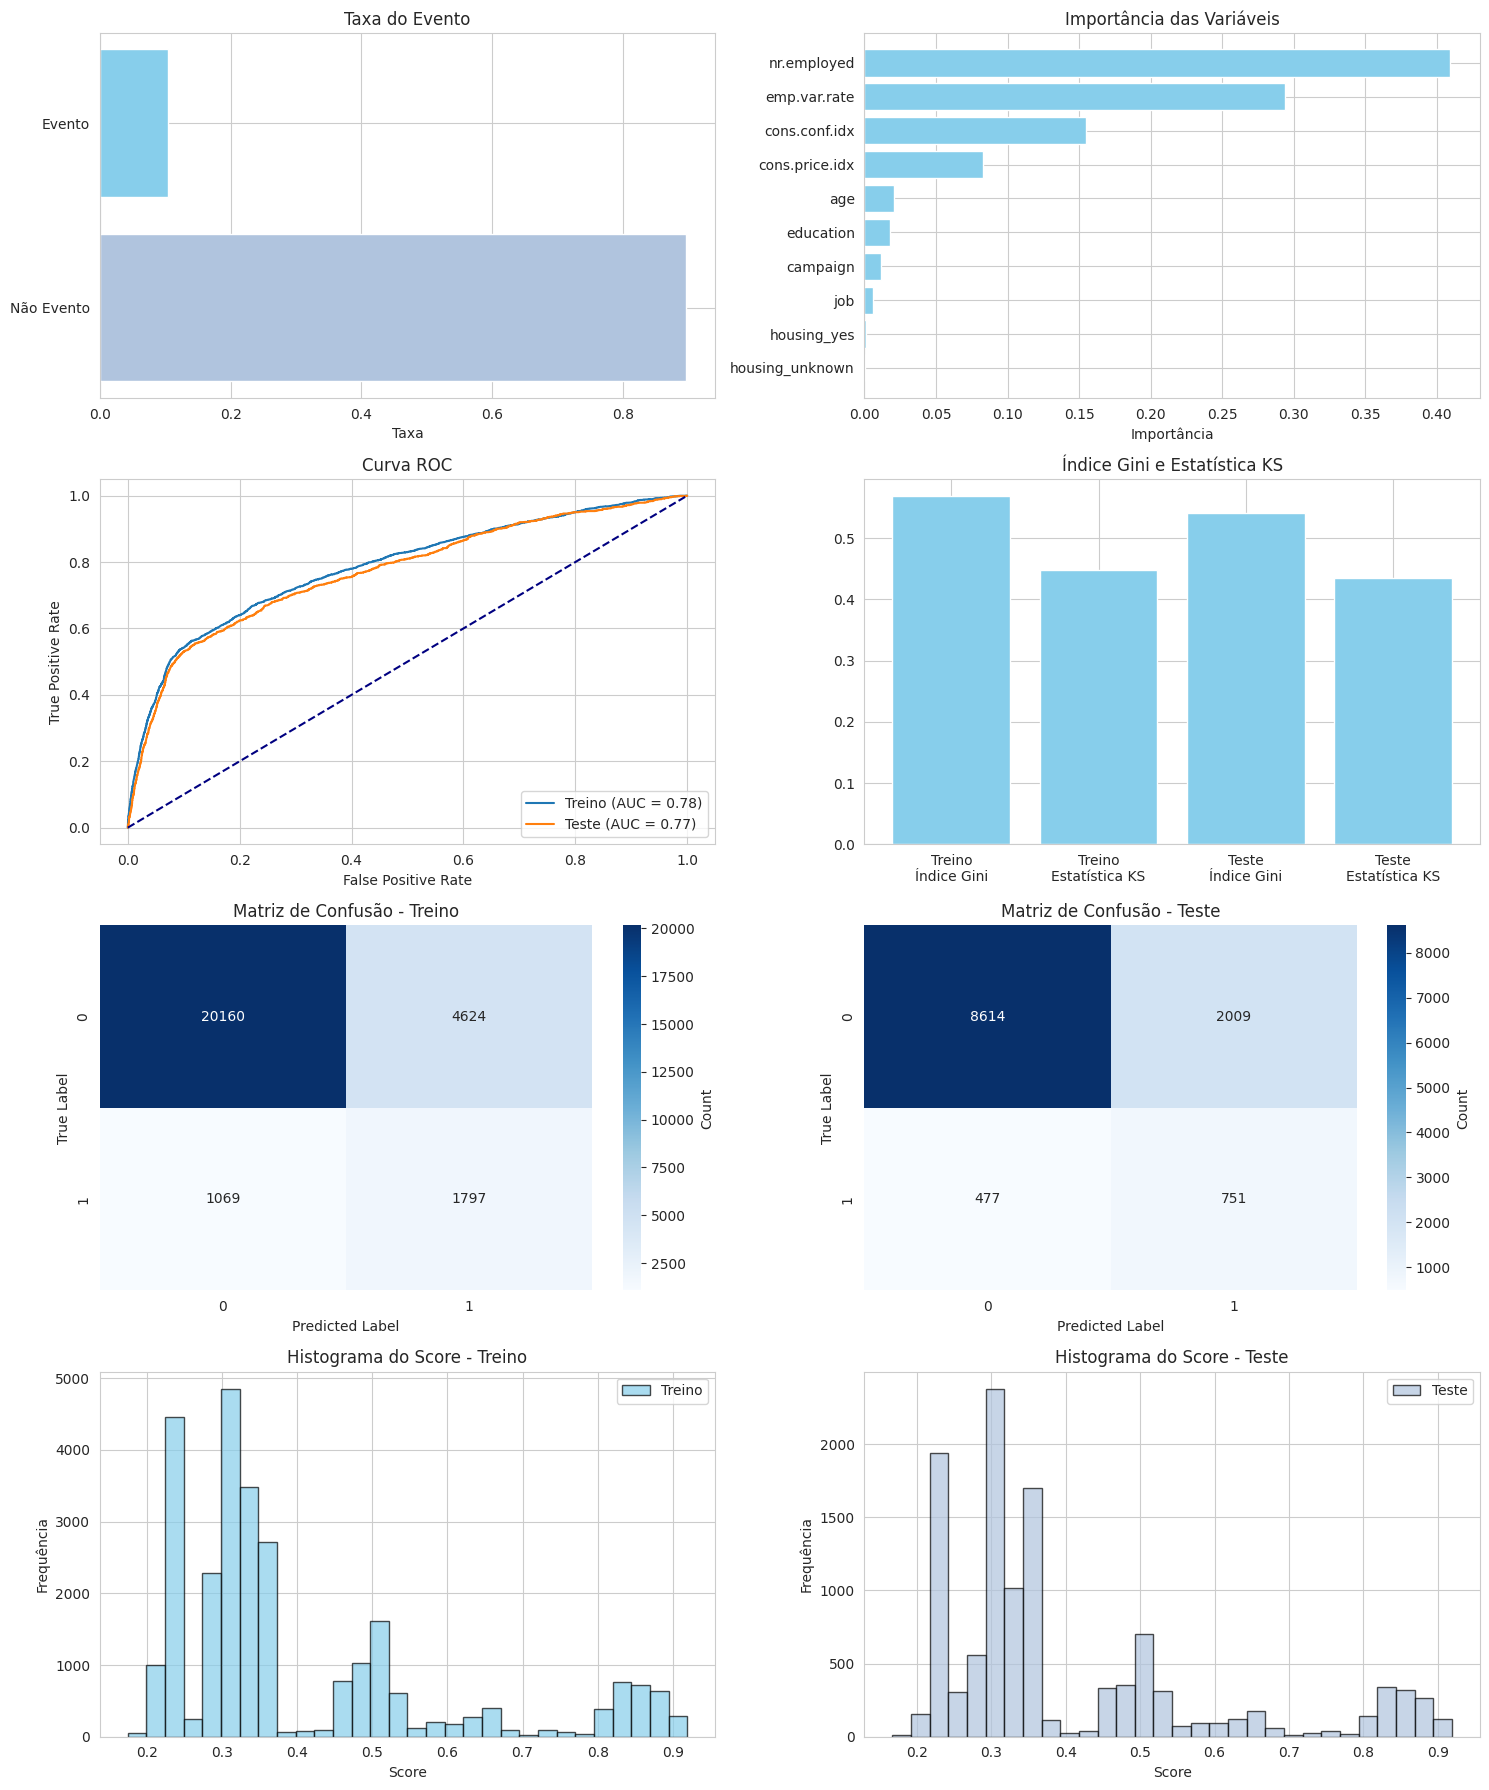

In [165]:
# Visualizando as métricas

plot_metrics(rf_opt, X_train, y_train, X_test, y_test)

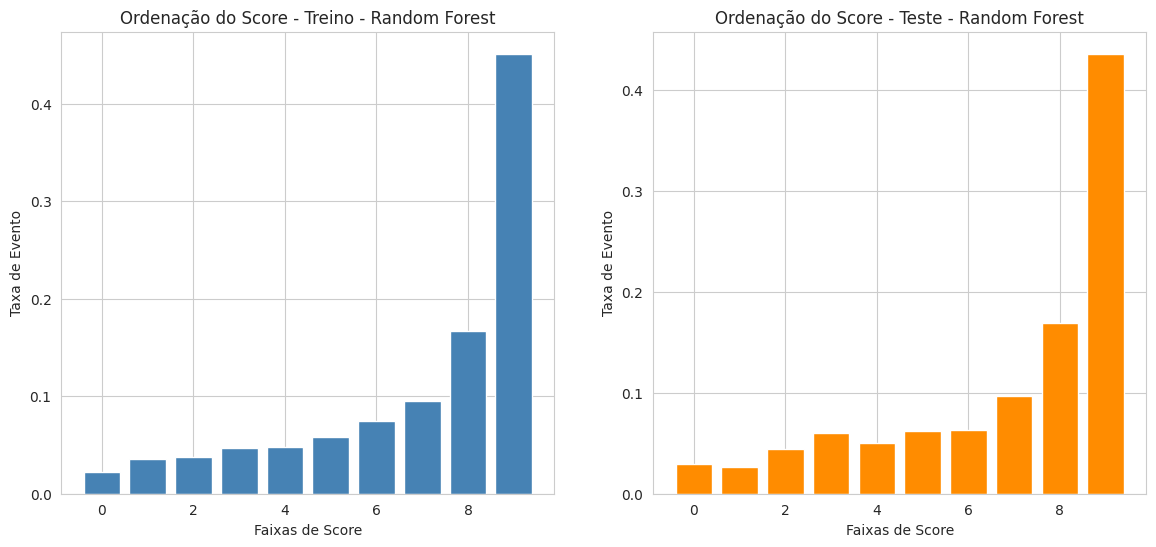

In [203]:
# Visualizando a ordenação do score
ordena_score(rf_opt, 'Random Forest', X_train, X_test, y_train, y_test)

#Evaluation

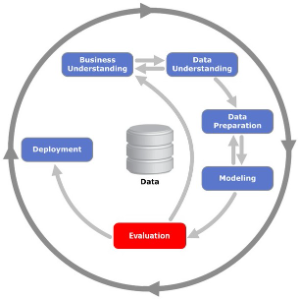

Reavaliando o modelo do ponto de vista do negócio, observa-se que:

<br>

**Taxa de evento:**

  Mantém a proporção do conjunto de dados inicial, que é de aproximadamente 10.4% de evento (saída de target igual a 1 - prepensão à compra)

<br>

**Importância das variáveis:**

Agora, a importância das features está com melhor distribuição e o modelo não ficará dependente de uma única variável. Dessa forma, é possível dar continuidade com a produtização do modelo.

<br>

**Métricas do modelo nos dados de teste**:
Os valores das principais métricas de avaliação do modelo são:
* AUC-ROC: 0.77
* Gini: 0.54
* KS: 0.44

Os valores estão muito próximos dos encontrados para o primeiro modelo e atendem Á eficiência mínima exigida pelo negócio.


<br>

**Matriz de confusão**:

Assim como no primeiro modelo, os erros cometidos em relação aos falsos negativos são menores do que os comentidos em relação aos falsos positivos. Sendo assim, essa informação também atende aos requisitos do negócio.

<br>

**Ordenação do score**:
Em duas faixas, nos dados de teste, a taxa de crescimento de score é negativa. Porém, observando todo o conjunto de faixas, observa-se a tendência de ordenação.


**Aprovação do modelo:**

As métricas e informações de desempenho observadas acima atendem aos requisitos do negócio e validam o modelo para produtização.



---




In [ ]:
# Escoragem das tabelas

X_train_score = X_train.copy()
X_train_score['class'] = rf_opt.predict(X_train)
X_train_score['score'] = rf_opt.predict_proba(X_train)[:,1]

X_test_score = X_test.copy()
X_test_score['class'] = rf_opt.predict(X_test)
X_test_score['score'] = rf_opt.predict_proba(X_test)[:,1]


In [ ]:
# Visualizando
X_test_score.head()

,age,job,education,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,housing_unknown,housing_yes,class,score
20368,31,9,3,1,1.4,93.444,-36.1,5228.1,0.0,1.0,0,0.310997
3249,35,7,3,3,1.1,93.994,-36.4,5191.0,0.0,1.0,0,0.236311
3332,42,0,6,3,1.1,93.994,-36.4,5191.0,0.0,0.0,0,0.236024
23660,29,0,6,20,1.4,93.444,-36.1,5228.1,0.0,1.0,0,0.240805
33662,37,0,6,1,-1.8,92.893,-46.2,5099.1,0.0,1.0,1,0.518230


#Deployment

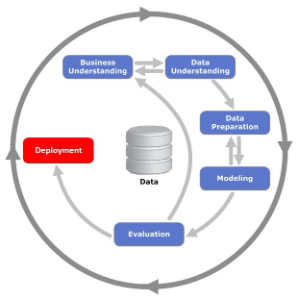

## Em desenvolvimento...